# DESI PV Y1 $z$-bin TFR Calibration

In redshift bins of width 0.001 (or 0.005), identify DESI observations with measurements suitable for the Tully-Fisher relation. Export the SGA IDs of the TFR galaxies and apply a multi-bin joint fit to calibrate the TFR at $0.4R_{26}$.

Version: **4 August 2025**

**Note:** This requires using a subclassed version of `hyperfit`.

In [1]:
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = False
from matplotlib import cm, colors
from matplotlib.patches import Ellipse
import matplotlib as mpl

# We have more than 10 redshift bins, so we need to change the default color map so that they are all plotted with different colors
# from cycler import cycler
# plt.rcParams['axes.prop_cycle'] = cycler('color', plt.get_cmap('tab20').colors)

import ligo.skymap.plot

from astropy.table import Table, vstack, join
from astropy.coordinates import SkyCoord, Distance
from astropy.cosmology import Planck18, LambdaCDM
from astropy.wcs import WCS
from astropy.visualization.wcsaxes import SphericalCircle
from astropy import units as u
from astropy import constants as c

from scipy.spatial.distance import cdist, euclidean

import os

from corner import corner

import pickle

from tqdm import tqdm

from matplotlib.projections import get_projection_names

from desiutil.plots import init_sky

# Custom functions / classes
import sys
# sys.path.insert(1, '/global/u1/k/kadglass/DESI_SGA/TF/')
sys.path.insert(1, '/Users/kdouglass/Documents/Research/DESI/PV_survey/code/TF/')
from help_functions import adjust_lightness
from line_fits import hyperfit_line_multi
from TF_photoCorrect import BASS_corr, MW_dust, k_corr, internal_dust
from z_CMB_convert import convert_z_frame

/Users/kdouglass/miniforge3/envs/desi/lib/python3.10/site-packages/ligo/lw/lsctables.py:89: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal


In [2]:
# Base values for later conversions (all in units in km/s).
c_kms = c.c.to_value('km/s')

h = 1.
H0 = 100*h

q0 = 0.2

# Access SGA Iron Data

The following selections have already been applied:
* `DELTACHI2 > 25` & `ZWARN = 0` for the centers
* $10 < V < 1000$ km/s and $\Delta V / V_\text{min}$ for the observations at $0.4R_{26}$
* Visual inspection

In [3]:
# sgapath = '/global/cfs/cdirs/desi/science/td/pv/tfgalaxies/Y1'
sgapath = '.'
# sgafits = os.path.join(sgapath, 'SGA-2020_iron_Vrot.fits')
# sgafits = os.path.join(sgapath, 'SGA-2020_iron_Vrot_VI.fits')
# sgafits = os.path.join(sgapath, 'SGA-2020_iron_Vrot_VI_photsys.fits')
sgafits = os.path.join(sgapath, 'SGA-2020_iron_Vrot_dVsys_VI_photsys.fits')

sgatab = Table.read(sgafits)
sgatab[:5]

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT,Z_DESI,ZERR_DESI,V_0p4R26,V_0p4R26_ERR,PHOTSYS
int64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float64,float64,float64,float64,bytes1
38,SGA-2020 38,SDSSJ140638.88+393138.1,3558705,211.66194,39.5272341,S?,81.63,0.35318315,0.37757218,0.08108376,24.72948,18.361,False,LEDA-20181114,12,SDSSJ140638.88+393138.1,1,True,211.66194,39.5272341,0.35318315,2115p395,211.66203166014844,39.52724032794356,0.41757938,SB26,82.21093,0.41431504,211.6619547015994,39.52729608884245,8.520181,5.252184,4.0750155,3.3951538,3.3006833,4.4037066,5.5453897,6.693271,7.8023033,8.999919,10.213078,11.41192,12.527382,19.246052,18.406073,17.931826,18.841032,18.092857,17.659027,18.566164,17.886087,17.47688,18.383362,17.749825,17.355968,18.261652,17.655558,17.284552,18.168955,17.588947,17.231817,18.101948,17.547142,17.20673,18.055267,17.516266,17.18719,18.023865,17.497095,17.178627,0.041267984,0.058114093,0.082968995,0.08808186,0.099526815,0.11876543,0.11355961,0.14645264,0.17035669,0.028041152,0.045385383,0.052895926,0.02822557,0.041093465,0.04698563,0.027371243,0.038240846,0.043213904,0.026219657,0.03618844,0.04070005,0.025270721,0.034526117,0.039107796,0.024264116,0.033164512,0.03780495,0.02343744,0.03226152,0.037176747,0.022813411,0.031564914,0.036686495,0.022342678,0.031088097,0.03649375,17.87426,0.7614885,0.3679447,2.3644495,0.004768816,17.421976,0.45777154,0.33258685,2.8184628,0.021122098,17.150808,0.27153513,0.24329957,3.8143618,0.0151183605,0,0.0809898865247745,2.365240555641251e-05,122.3223893029039,9.671537005812278,N
55,SGA-2020 55,PGC1203947

## Compute intrinsic size for each galaxy

Using this to define dwarfs: those with $R_{26} \leq 5$ kpc/h.

In [4]:
Planck18_h = LambdaCDM(H0=100, 
                       Om0=Planck18.Om0, 
                       Tcmb0=Planck18.Tcmb0, 
                       Neff=Planck18.Neff, 
                       m_nu=Planck18.m_nu, 
                       Ob0=Planck18.Ob0, 
                       Ode0=Planck18.Ode0)

In [5]:
dist = Distance(z=np.abs(sgatab['Z_DESI']), cosmology=Planck18_h)

sgatab['D26_kpc'] = 2*dist.to('kpc')*np.tan(0.5*sgatab['D26']*u.arcmin)

In [6]:
dwarf_boolean = 0.5*sgatab['D26_kpc'] <= 5

## Convert to CMB frame

In [7]:
sgatab['Z_DESI_CMB'] = convert_z_frame(sgatab['Z_DESI'], sgatab['RA'], sgatab['DEC'])

# Load Morphological Classification

## SSL

As an alternative to morphological classification of the galaxies, we also produced a classification based on the SSL sorter (using a nearest-neighbor query; Largett et al., in prep.). The classification ignored the Hubble sub-types and grouped the galaxies into four main categories:
1. Spiral
2. Elliptical
3. Lenticular
4. Irregular

Let's also load this table and add it to the SGA table.

In [8]:
# ai_morphpath = '/global/cfs/cdirs/desi/science/td/pv'
ai_morphpath = '.'
# ai_morphpath = '/global/cfs/cdirs/desi/science/td/pv/SGA2020'
# ai_morphcsv = os.path.join(ai_morphpath, 'sga10278_morphologies_model_analysis.csv')
ai_morphcsv = os.path.join(ai_morphpath, 'TFY1_Classification.csv')

ai_morphtab = Table.read(ai_morphcsv)
ai_morphtab

SGA_ID,Spiral_Pred,Elliptical_Pred,Lenticular_Pred,Irregular_Pred
float64,str6,str10,str10,str9
2371.0,Other,Other,Other,Irregular
2406.0,Spiral,Other,Other,Other
4614.0,Spiral,Other,Other,Other
7707.0,Spiral,Other,Other,Other
8119.0,Spiral,Other,Other,Other
8832.0,Spiral,Other,Other,Other
9415.0,Other,Other,Other,Irregular
11933.0,Spiral,Other,Other,Other
12347.0,Other,Other,Other,Irregular


In [9]:
# Create an overall record of the SSL prediction
ai_morphtab['Predicted_Type'] = 'Undecided '

for i in range(len(ai_morphtab)):
    
    classes = ai_morphtab['Spiral_Pred', 'Elliptical_Pred', 'Lenticular_Pred', 'Irregular_Pred'][i]
    
    ai_morphtab['Predicted_Type'][i] = next(j for j in classes if j != 'Other')

### Combine ML morphtypes with SGA catalog

In [10]:
sgatab = join(sgatab, ai_morphtab['SGA_ID', 'Predicted_Type'], keys='SGA_ID', join_type='left')

# Rename Predicted_Type to MORPHTYPE_AI
sgatab['Predicted_Type'].name = 'MORPHTYPE_AI'

## John Lucey's VI results

https://astro.dur.ac.uk/~jrl/DESI_TF_Y1/index.html

We are only considering galaxies that he considers bad for TF (strong asymmetry, double galaxies, stellar contamination).

In [11]:
lucey_VIpath = 'VI_JohnLucey/'

rejects = lucey_VIpath + 'REJECTS.txt'

reject_tab = Table.read(rejects, format='ascii.commented_header')
reject_tab['VI'] = 'reject'
reject_tab

SGA_ID,DESI_NAME,RA,Dec,z_desi,V_0p4R26,V_0p4R26_err,V_PEC,V_ERR_PEC,VI
int64,str22,float64,float64,float64,int64,int64,int64,int64,str6
18171,DESIXJ21105773+0109527,317.74056,1.164637,0.0903,219,1,-555,542,reject
18900,DESIXJ13403122+0437086,205.130097,4.619043,0.0224,52,2,2647,351,reject
20828,DESIXJ20452158-0505449,311.339907,-5.095804,0.0522,97,1,9894,335,reject
24403,DESIXJ13023920-0257343,195.663329,-2.959515,0.0675,222,1,-2594,411,reject
34318,DESIXJ15173290+0109051,229.38709,1.151405,0.1257,235,38,7564,7706,reject
43314,DESIXJ19180598+6436397,289.524898,64.611027,0.0255,104,2,1327,299,reject
61768,DESIXJ23195165+0025234,349.965218,0.423153,0.0341,123,0,-305,278,reject
63092,DESIXJ14161558-0127527,214.064897,-1.46464,0.0363,149,0,-5767,286,reject
65921,DESIXJ21443087-0617367,326.12863,-6.293535,0.09,89,21,26924,8751,reject


### Combine John's results with Y1 TF sample

In [12]:
sgatab = join(sgatab, reject_tab['SGA_ID', 'VI'], keys='SGA_ID', join_type='left')

# Rename VI column to JOHN_VI
sgatab['VI'].name = 'JOHN_VI'

In [13]:
sgatab[:5]

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT,Z_DESI,ZERR_DESI,V_0p4R26,V_0p4R26_ERR,PHOTSYS,D26_kpc,Z_DESI_CMB,MORPHTYPE_AI,JOHN_VI
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,kpc,,,
float64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float64,float64,float64,float64,bytes1,float64,float64,str10,str6
38.0,SGA-2020 38,SDSSJ140638.88+393138.1,3558705,211.66194,39.5272341,S?,81.63,0.35318315,0.37757218,0.08108376,24.72948,18.361,False,LEDA-20181114,12,SDSSJ140638.88+393138.1,1,True,211.66194,39.5272341,0.35318315,2115p395,211.66203166014844,39.52724032794356,0.41757938,SB26,82.21093,0.41431504,211.6619547015994,39.52729608884245,8.520181,5.252184,4.0750155,3.3951538,3.3006833,4.4037066,5.5453897,6.693271,7.8023033,8.999919,10.213078,11.41192,12.527382,19.246052,18.406073,17.931826,18.841032,18.092857,17.659027,18.566164,17.886087,17.47688,18.383362,17.749825,17.355968,18.261652,17.655558,17.284552,18.168955,17.588947,17.231817,18.101948,17.547142,17.20673,18.055267,17.516266,17.18719,18.023865,17.497095,17.178627,0.041267984,0.058114093,0.082968995,0.08808186,0.099526815,0.11876543,0.11355961,0.14645264,0.17035669,0.028041152,0.045385383,0.052895926,0.02822557,0.041093465,0.04698563,0.027371243,0.038240846,0.043213904,0.026219657,0.03618844,0.04070005,0.025270721,0.034526117,0.039107796,0.024264116,0.033164512,0.03780495,0.02343744,0.03226152,0.037176747,0.022813411,0.031564914,0.036686495,0.022342678,0.031088097,0.03649375,17.87426,0.7614885,0.3679447,2.3644495,0.004768816,17.421976

# Apply Cuts Suitable for Calibrating the TFR

Requirements:
* $10~\mathrm{km/s} < V_\mathrm{rot} < 1000~\mathrm{km/s}$ at $0.4R_{26}$
* $\Delta V/V_\mathrm{min} \leq 5$
* Passed visual inspection (both ours and John Lucey's)
* $i > 45^\circ$
* Spiral-type morphology
* Not a dwarf galaxy

The first 2.5 items have already been applied (our VI results have already been applied, but not John's).

In [14]:
#- Inclination cut
cosi2 = (sgatab['BA']**2 - q0**2) / (1 - q0**2)
i_min = 45. * u.degree
cosi2_max = np.cos(i_min)**2
is_good_incl = cosi2 < cosi2_max

#- Morphology cut: only ML
is_good_morph_ML = np.zeros_like(is_good_incl, dtype=bool)
for i in range(len(sgatab)):
    if sgatab['MORPHTYPE_AI'][i] == 'Spiral':
        is_good_morph_ML[i] = True

#- John's VI
is_good_John = sgatab['JOHN_VI'].mask

#- Combine selections:
is_good_sga = is_good_incl & is_good_morph_ML & is_good_John & ~dwarf_boolean

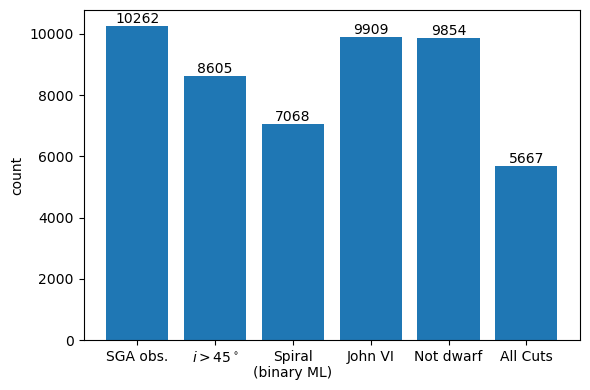

In [15]:
data = {
    'SGA obs.' : len(sgatab),
    # r'$10 < V_\mathrm{rot} < 1000$' : np.sum(is_good_velo),
    # r'$\Delta V/V_\mathrm{min}>5$' : np.sum(is_good_dv),
    r'$i > 45^\circ$' : np.sum(is_good_incl), 
    # 'Spiral' : np.sum(is_good_morph),
    'Spiral\n(binary ML)' : np.sum(is_good_morph_ML),
    'John VI' : np.sum(is_good_John), 
    'Not dwarf' : np.sum(~dwarf_boolean), 
    'All Cuts' : np.sum(is_good_sga), 
    # 'All Cuts\n(binary ML)' : np.sum(is_good_sga_ML)
}
names = list(data.keys())
values = list(data.values())

fig, ax = plt.subplots(1, 1, figsize=(6,4), tight_layout=True)
bars = ax.bar(names, values, color='tab:blue')
ax.bar_label(bars, fmt='%d')
ax.set(ylabel='count');#, yscale='log', ylim=[1e3,1.2e4]);

# fig.savefig('../../Figures/Y1/TF_Y1_SGA_Vrot_cuts.png', dpi=150, facecolor='none');

# Photometric corrections

### Survey offsets

In [16]:
sys_corr, sys_corr_err = BASS_corr(sgatab['PHOTSYS'])

### MW dust corrections

In [17]:
# Import E(B-V) dust map
# ebv_directory = '/global/cfs/cdirs/desicollab/users/rongpu/dust/desi_ebv/public_data/maps/'
ebv_directory = '/Users/kdouglass/Documents/Research/data/DESI/'
ebv_filename = 'desi_dust_gr_512.fits'
ebv_map = Table.read(ebv_directory + ebv_filename)

In [18]:
MWdust_corr, MWdust_corr_err = MW_dust(sgatab['RA'], sgatab['DEC'], ebv_map)

/Users/kdouglass/Documents/Research/DESI/PV_survey/code/TF/TF_photoCorrect.py:90: UserWarning: Warning: converting a masked element to nan.
  EBV_err[i] = ebv_map['EBV_GR_ERR'][i_ebv]


In [19]:
# Flip NaN values to 0
MWdust_corr_err[np.isnan(MWdust_corr_err)] = 0

### $K$-corrections

In [20]:
# Apparently we have some galaxies with negative redshifts
zg0 = sgatab['Z_DESI'] >= 0

In [21]:
kcorr_zg0 = k_corr(sgatab['Z_DESI'][zg0], 
                   [sgatab['G_MAG_SB26'][zg0], sgatab['R_MAG_SB26'][zg0], sgatab['Z_MAG_SB26'][zg0]], 
                   [sgatab['G_MAG_SB26_ERR'][zg0], sgatab['R_MAG_SB26_ERR'][zg0], sgatab['Z_MAG_SB26_ERR'][zg0]], 
                   z_corr=0.1) # K-correcting to same redshift as FastSpecFit (which is what Caitlin's using for the FP)

In [22]:
kcorr = np.zeros([len(sgatab), 3])
kcorr[zg0] = kcorr_zg0

### Internal dust extinction correction

This is based off of a linear fit to ($b/a$, $m_r$), removing any correlation between $b/a$ and $m_r$.

In [23]:
temp_infile = open('iron_internalDust_z0p1_mcmc.pickle', 'rb')
dust_mcmc_samples_r,_, dust_mcmc_samples_g,_, dust_mcmc_samples_z,_ = pickle.load(temp_infile)
temp_infile.close()

In [24]:
internalDust_coeffs_r = np.median(dust_mcmc_samples_r, axis=1)
internalDust_coeffs_g = np.median(dust_mcmc_samples_g, axis=1)
internalDust_coeffs_z = np.median(dust_mcmc_samples_z, axis=1)

internalDust_coeffs_err_r = np.zeros(len(internalDust_coeffs_r))
internalDust_coeffs_err_g = np.zeros(len(internalDust_coeffs_g))
internalDust_coeffs_err_z = np.zeros(len(internalDust_coeffs_z))

internalDust_coeffs_err_r[0] = np.std(dust_mcmc_samples_r[0][(-1.5 < dust_mcmc_samples_r[0]) & (dust_mcmc_samples_r[0] < 0)])
internalDust_coeffs_err_r[1] = np.std(dust_mcmc_samples_r[1][(0 < dust_mcmc_samples_r[1]) & (dust_mcmc_samples_r[1] < 1)])

internalDust_coeffs_err_g[0] = np.std(dust_mcmc_samples_g[0][(-1.5 < dust_mcmc_samples_g[0]) & (dust_mcmc_samples_g[0] < 0)])
internalDust_coeffs_err_g[1] = np.std(dust_mcmc_samples_g[1][(0 < dust_mcmc_samples_g[1]) & (dust_mcmc_samples_g[1] < 1)])

internalDust_coeffs_err_z[0] = np.std(dust_mcmc_samples_z[0][(-1.5 < dust_mcmc_samples_z[0]) & (dust_mcmc_samples_z[0] < 0)])
internalDust_coeffs_err_z[1] = np.std(dust_mcmc_samples_z[1][(0 < dust_mcmc_samples_z[1]) & (dust_mcmc_samples_z[1] < 1)])

In [25]:
internalDust_corr_r, internalDust_corr_err_r = internal_dust(sgatab['BA'], 
                                                             internalDust_coeffs_r, 
                                                             internalDust_coeffs_err_r)

internalDust_corr_g, internalDust_corr_err_g = internal_dust(sgatab['BA'], 
                                                             internalDust_coeffs_g, 
                                                             internalDust_coeffs_err_g)

internalDust_corr_z, internalDust_corr_err_z = internal_dust(sgatab['BA'], 
                                                             internalDust_coeffs_z, 
                                                             internalDust_coeffs_err_z)

## Apply corrections

In [26]:
sgatab['G_MAG_SB26_CORR'] = sgatab['G_MAG_SB26'] - MWdust_corr[0] + sys_corr + kcorr[:,0] - internalDust_corr_g
sgatab['R_MAG_SB26_CORR'] = sgatab['R_MAG_SB26'] - MWdust_corr[1] + sys_corr + kcorr[:,1] - internalDust_corr_r
sgatab['Z_MAG_SB26_CORR'] = sgatab['Z_MAG_SB26'] - MWdust_corr[2] + sys_corr + kcorr[:,2] - internalDust_corr_z

In [27]:
sgatab['G_MAG_SB26_ERR_CORR'] = np.sqrt(sgatab['G_MAG_SB26_ERR']**2 + MWdust_corr_err[0]**2 + sys_corr_err**2 + internalDust_corr_err_g**2)
sgatab['R_MAG_SB26_ERR_CORR'] = np.sqrt(sgatab['R_MAG_SB26_ERR']**2 + MWdust_corr_err[1]**2 + sys_corr_err**2 + internalDust_corr_err_r**2)
sgatab['Z_MAG_SB26_ERR_CORR'] = np.sqrt(sgatab['Z_MAG_SB26_ERR']**2 + MWdust_corr_err[2]**2 + sys_corr_err**2 + internalDust_corr_err_z**2)

## Load SN Ia Calibrators for the TFR Zero Point

Updated (July 2025) list of SNe Ia from UNION3 and Pantheon+ from Anthony Carr. Match these to the SGA iron observations that have passed all quality cuts.

In [28]:
# zeroptpath = '/global/cfs/cdirs/desi/science/td/pv/combinedpv'
zeroptpath = '.'

In [29]:
zeroptab_all = Table.read(os.path.join(zeroptpath, 'PVsample_group_lookup+SNe.csv'))

# This is a list of all the TF + FP galaxies; only keep those with non-zero `MU_SN`
zeroptab_secondary = zeroptab_all[zeroptab_all['MU_SN'] > 0]
zeroptab_secondary[:5]

ID,group,zcmb,MU,MU_ERR,LOGDIST,LOGDIST_ERR,FP_FLAG,MU_FP,MU_FP_ERR,MU_TF,MU_TF_ERR,LOGDIST_FP,LOGDIST_FP_ERR,LOGDIST_TF,LOGDIST_TF_ERR,zcmb_gr,MU_SN,MU_SN_ERR,MU_DESI,MU_DESI_ERR,LOGDIST_SN,LOGDIST_SN_ERR,LOGDIST_DESI,LOGDIST_DESI_ERR
int64,str11,float64,float64,float64,float64,float64,str5,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
39633328785066757,2MRS711+,0.0039676663986918,32.00097867224519,0.6604661904704527,-0.3237695642772998,0.13209323809409051,True,31.73849041214853,0.48077000045780094,0.0,0.0,-0.24903482597904422,0.0961540000915601,0.0,0.0,0.0039533333333333,31.666571207539782,0.09129591053344505,31.738468671967322,0.48044940574448897,-0.28848911070838973,0.01825918210668901,-0.24902863619077392,0.09608988114889777
39633335592422861,2MRS711+,0.0044219686972581,31.443432913341425,0.7001885307384135,-0.16502708807805433,0.14003770614768266,True,31.73849041214853,0.48077000045780094,0.0,0.0,-0.24903482597904422,0.0961540000915601,0.0,0.0,0.0039533333333333,31.666571207539782,0.09129591053344505,31.738468671967322,0.48044940574448897,-0.28848911070838973,0.01825918210668901,-0.24902863619077392,0.09608988114889777
530182,2MRS99+,0.0047930320652416,32.47940875769096,0.7239065513601364,-0.3371487771800957,0.1447813102720272,False,30.929053813819788,0.31756824198384404,32.47940875769096,0.7239065513601364,0.03345970227711499,0.06351364839676879,-0.3371487771800957,0.1447813102720272,0.0058240909090909,32.4685,0.3462250857462526,31.17818507964822,0.29021798422398415,-0.23484747112467588,0.06924501714925052,-0.02609430598306092,0.05804359684479681
2842557700636673,2MRS99+,0.0061633210470812,30.47296800289217,0.7404426954770842,0.17379783886345607,0.14808853909541678,True,30.929053813819788,0.31756824198384404,32.47940875769096,0.7239065513601364,0.03345970227711499,0.06351364839676879,-0.3371487771800957,0.1447813102720272,0.0058240909090909,32.4685,0.3462250857462526,31.17818507964822,0.29021798422398415,-0.23484747112467588,0.06924501714925052,-0.02609430598306092,0.05804359684479681
2842569767649280,2MRS99+,0.0072261998346456,30.84064192659754,0.6981248856923716,0.1697020751725316,0.13962497713847433,True,30.929053813819788,0.31756824198384404,32.47940875769096,0.7239065513601364,0.03345970227711499,0.06351364839676879,-0.3371487771800957,0.1447813102720272,0.0058240909090909,32.4685,0.3462250857462526,31.17818507964822,0.29021798422398415,-0.23484747112467588,0.06924501714925052,-0.02609430598306092,0.05804359684479681


In [30]:
# zeroptab_primary = Table.read(os.path.join(zeroptpath, 'new_Pplus_group_match+SGA.csv'))
zeroptab_primary = Table.read(os.path.join(zeroptpath, 'new_Pplus_group_match+SGA_avg.csv'))
zeroptab_primary[:5]

CID,zCMB,zCMBERR,zHEL,zHELERR,MU_SH0ES,MU_SH0ES_ERR_DIAG,CEPH_DIST,IS_CALIBRATOR,USED_IN_SH0ES_HF,RA_SN,DEC_SN,ID_gr,ID_gal,ra_Lim,dec_Lim,source,sep_SN-Lim,SGA_ID,sep_Lim-SGA
str15,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64,float64,str9,str19,float64,float64,str9,float64,float64,float64
SN2016esh,0.04488,3e-05,0.04457,3e-05,36.1579,0.12988610395265537,-9.0,0,0,241.06,16.6902,SDSS228,SDSS581524,241.05988,16.69016,SDSS228+,0.4311776000325898,--,--
ASASSN-16fo,0.02994,0.00021,0.0289,0.00021,35.4803,0.12944141531982722,-9.0,0,0,203.149,-5.2725,2dF15428,2dF128339,203.14912,-5.27278,2dF15428,1.0929274169111631,64475.0,0.4609341882013722
ASASSN-16ct,0.04252,4e-05,0.04191,4e-05,36.2457,0.14873066260862283,-9.0,0,0,228.476,4.7573,SDSS1466,SDSS102315,228.47627,4.75715,SDSS1466,1.115336665428975,--,--
ASASSN-15so,0.00773,1e-05,0.00702,1e-05,32.7527,0.1274923134937946,32.8026,1,0,168.546,48.3187,2MRS4707,2MRS662,168.54575,48.31838,2MRS4707+,1.3004787534374072,995356.0,0.9298391203772391
ASASSN-15la,0.02845,1e-05,0.02782,1e-05,35.0558,0.15650734807030628,-9.0,0,1,213.213,35.7112,SDSS962,SDSS302584,213.21349,35.71089,2MRS834+,1.8232536690592336,737288.0,0.200539881958872


In [31]:
# Remove non-SGA galaxies
zeroptab_primary_SGA = zeroptab_primary[~zeroptab_primary['SGA_ID'].mask]

In [32]:
# Join the two 0pt catalogs together
zeroptab = join(zeroptab_secondary['ID', 'MU_SN', 'MU_SN_ERR', 'group'], 
                zeroptab_primary_SGA['SGA_ID', 'MU_SH0ES', 'MU_SH0ES_ERR_DIAG', 'CID'], 
                keys_left='ID', keys_right='SGA_ID', 
                join_type='outer')
zeroptab[:5]

ID,MU_SN,MU_SN_ERR,group,SGA_ID,MU_SH0ES,MU_SH0ES_ERR_DIAG,CID
int64,float64,float64,str11,float64,float64,float64,str15
--,--,--,--,10461.0,35.9905,0.2810696710781866,2007hu
--,--,--,--,20779.0,35.8698,0.13604785922608265,ASASSN-16db
--,--,--,--,22915.0,35.0136,0.17318562295987505,SNF20080514-002
--,--,--,--,37527.0,36.3303,0.09554459691683251,1995ac
40926,37.032,0.1278163917500412,2dF416+,--,--,--,--


In [33]:
# Merge together the ID and SGA_ID columns
zeroptab['SGA_ID'][zeroptab['SGA_ID'].mask] = zeroptab['ID'][zeroptab['SGA_ID'].mask]

# Remmove "old" ID column
zeroptab.remove_column('ID')

zeroptab[:5]

MU_SN,MU_SN_ERR,group,SGA_ID,MU_SH0ES,MU_SH0ES_ERR_DIAG,CID
float64,float64,str11,float64,float64,float64,str15
--,--,--,10461.0,35.9905,0.2810696710781866,2007hu
--,--,--,20779.0,35.8698,0.13604785922608265,ASASSN-16db
--,--,--,22915.0,35.0136,0.17318562295987505,SNF20080514-002
--,--,--,37527.0,36.3303,0.09554459691683251,1995ac
37.032,0.1278163917500412,2dF416+,40926.0,--,--,--


In [34]:
#- Extract the 0-point SNe Ia that match SGA IDs in the good catalog (passed all rotation curve cuts).
idx = np.isin(zeroptab['SGA_ID'], sgatab['SGA_ID'][is_good_sga])

#  Merge the tables so we can use the zero point later.
zeroptab = join(sgatab, zeroptab[idx], keys='SGA_ID')

#- Write catalog to file
# zeroptab.write('SGA_distances_0pt_iron_z0p1.fits', overwrite=True)
zeroptab['SGA_ID', 'GALAXY', 'MU_SN', 'MU_SH0ES', 'group', 'CID'].show_in_notebook()

         interactive tables it is recommended to use dedicated tools like:
         - https://github.com/bloomberg/ipydatagrid
         - https://docs.bokeh.org/en/latest/docs/user_guide/interaction/widgets.html#datatable
         - https://dash.plotly.com/datatable [warnings]


idx,SGA_ID,GALAXY,MU_SN,MU_SH0ES,group,CID
0,40926.0,PGC1068066,37.032,--,2dF416+,--
1,109750.0,PGC007299,36.481301221344594,36.481301221344594,2005hc+,2005hc+
2,124900.0,PGC1111212,36.8581,--,2dF2679+,--
3,185629.0,PGC1313612,35.825,--,SDSS32+,--
4,236390.0,PGC1093912,37.0786,--,2dF14+,--
5,364828.0,PGC1259192,35.6231,--,2MRS294+,--
6,431725.0,NGC1699,33.583117887482615,33.583117887482615,2MRS315+,2001ep+
7,506101.0,PGC1082809,37.0786,--,2dF14+,--
8,656304.0,PGC032277,36.1263,36.1263,2dF45+,PS16axi
9,719688.0,UGC08844,35.0276,--,6dF501+,--


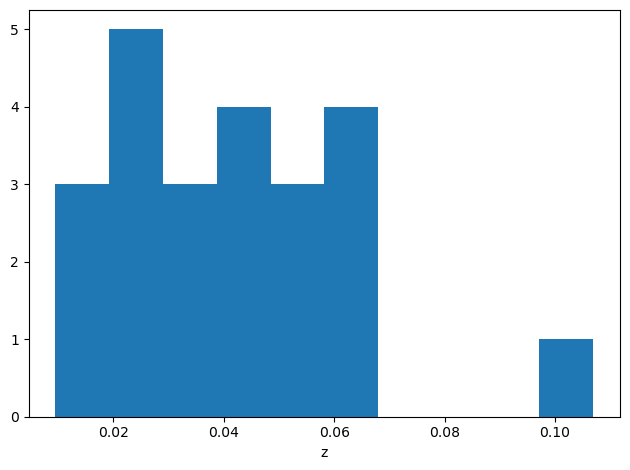

In [35]:
plt.figure(tight_layout=True)

plt.hist(zeroptab['Z_DESI'])#, bins=np.arange(0, 0.12, 0.0025))

plt.xlabel('z');

In [36]:
# Only keep galaxies with a primary SN match
# zeroptab = zeroptab[~zeroptab['MU_PRIMARY'].mask]

In [37]:
np.unique(zeroptab['CID'], return_counts=True)

(<MaskedColumn name='CID' dtype='str15' length=7>
 1999ac+
 2001ep+
 2005hc+
  500038
      --
 PS15cms
 PS16axi,
 array([ 1,  1,  1,  1, 17,  1,  1]))

### Plot the Zero Point Calibrators

Sky coordinates of the SNe with good DESI rotational velocities.

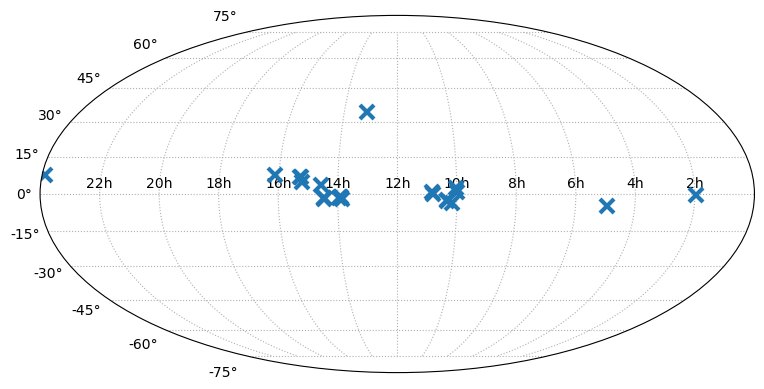

In [38]:
sne_coords = SkyCoord(ra=zeroptab['RA'], dec=zeroptab['DEC'], frame='icrs', unit='deg')

fig, ax = plt.subplots(figsize=(10,4), tight_layout=True, subplot_kw={'projection' : 'mollweide'})
_ra = np.radians(180*u.deg - sne_coords.ra)
_dec = np.radians(sne_coords.dec)
ax.plot(_ra, _dec, 'x', ms=10, mew=3)

ax.set(xticklabels=[f'{_}h' for _ in np.arange(2,24, 2)][::-1])
ax.grid(ls=':');

# fig.savefig('../../Figures/Y1/TF_Y1_SGA_Vrot_SNIa_calibrators.png', dpi=150);

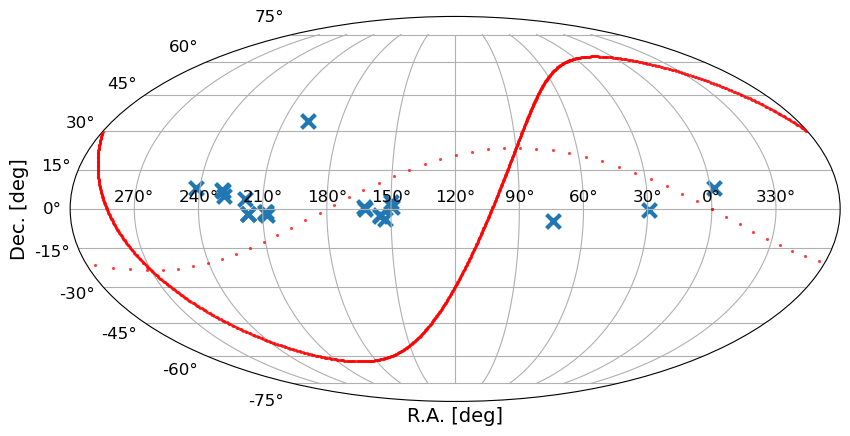

In [39]:
ax = init_sky()

ax.scatter(ax.projection_ra(sne_coords.ra.value), 
           ax.projection_dec(sne_coords.dec.value), 
           marker='x', 
           s=100,
           linewidth=3,
           color='tab:blue')

ax.xaxis.label.set_size(14)
ax.yaxis.label.set_size(14)

plt.tick_params(axis='both', which='major', labelsize=12);

# plt.savefig('../../Figures/Y1/iron_0pt_sky_Anthony2.png', 
#             dpi=150, 
#             facecolor='none');

### Compute the Absolute Magnitude of the 0-pt Calibrators based on the Distance

Compute the absolute magnitude
$$
M_r - 5\log{h} = m_r - \mu - 5\log{h},
$$
where $h$ is the reduced Hubble constant used to calibrate the distance modulus $\mu$.

Since our calibrators are from Pantheon+SH0ES, where distances are based on the distance ladder, there is no assumed value of $h$.

In [40]:
#- Clean up the distance modulus
use_primary = ~zeroptab['MU_SH0ES'].mask
mu = zeroptab['MU_SN']
mu[use_primary] = zeroptab['MU_SH0ES'][use_primary]
# mu = zeroptab['MU_PRIMARY']

mu_err = zeroptab['MU_SN_ERR']
mu_err[use_primary] = zeroptab['MU_SH0ES_ERR_DIAG'][use_primary]

#- Compute the absolute magnitude
zeroptab['R_ABSMAG_SB26'] = zeroptab['R_MAG_SB26_CORR'] - mu
zeroptab['R_ABSMAG_SB26_ERR'] = np.sqrt(zeroptab['R_MAG_SB26_ERR_CORR']**2 + mu_err**2)

In [41]:
# Save this table
zeroptab.write('SGA-2020_iron_Vrot_VI_0pt-Anthony2_calib_z0p1_R26dwarfs.fits', 
               overwrite=True)

In [41]:
zeroptab['SGA_ID', 'D26_kpc', 'R_MAG_SB26', 'R_MAG_SB26_ERR', 'V_0p4R26', 'V_0p4R26_ERR'].show_in_notebook()

         interactive tables it is recommended to use dedicated tools like:
         - https://github.com/bloomberg/ipydatagrid
         - https://docs.bokeh.org/en/latest/docs/user_guide/interaction/widgets.html#datatable
         - https://dash.plotly.com/datatable [warnings]


idx,SGA_ID,D26_kpc,R_MAG_SB26,R_MAG_SB26_ERR,V_0p4R26,V_0p4R26_ERR
,,kpc,,,,
0,40926.0,28.58454771708347,16.696472,0.0065811076,136.35142178525604,11.074703336870135
1,109750.0,42.34779922242629,15.013978,0.0113418605,221.3755771256751,8.774282536170919
2,124900.0,26.760046348583327,16.818043,0.032047212,143.17112816644325,34.61067012636111
3,185629.0,15.943648701231227,16.74443,0.023938801,118.22404252663176,10.30302451309546
4,236390.0,29.201396206101446,17.108109,0.030829139,132.93922299389146,9.693889582725964
5,364828.0,15.101189979483186,17.001926,0.019800633,98.2998665738336,10.911703633791037
6,431725.0,18.98358140666423,13.250422,0.004055838,159.04723205510138,11.274472967436228
7,506101.0,32.09442197347618,16.420128,0.02698361,148.86839576404628,7.266022158130458
8,656304.0,23.69295520949068,15.03111,0.0047636353,181.73653288642595,10.048159182113666


# Redshift bins

Separate the galaxies into redshift bins of width 0.005, starting at a redshift of 0.03.  (PVs are a significant fraction of the redshift at redshifts less than this.)

In [57]:
zmin = 0.03
zmax = 0.1
dz = 0.001
zbins = np.arange(zmin, zmax + dz, dz)

#- SGA galaxies that passed quality selection
sgatab_sel = sgatab[is_good_sga]

zbin_indices = np.digitize(sgatab_sel['Z_DESI_CMB'], zbins, right=True)

In [58]:
for i in range(len(zbins) + 1):
    if i == 0:
        print(f'{i:2d}  z <= {zbins[i]:0.3f}  {np.sum(zbin_indices == i):3d} galaxies')
    elif i == len(zbins):
        print(f'{i:2d}  z > {zbins[i-1]:0.3f}  {np.sum(zbin_indices == i):3d} galaxies')
    else:
        print(f'{i:2d}  {zbins[i-1]:0.3f} < z <= {zbins[i]:0.3f}  {np.sum(zbin_indices == i):3d} galaxies')

 0  z <= 0.030  627 galaxies
 1  0.030 < z <= 0.031   93 galaxies
 2  0.031 < z <= 0.032   81 galaxies
 3  0.032 < z <= 0.033   90 galaxies
 4  0.033 < z <= 0.034   76 galaxies
 5  0.034 < z <= 0.035   86 galaxies
 6  0.035 < z <= 0.036   55 galaxies
 7  0.036 < z <= 0.037   77 galaxies
 8  0.037 < z <= 0.038   72 galaxies
 9  0.038 < z <= 0.039   67 galaxies
10  0.039 < z <= 0.040   78 galaxies
11  0.040 < z <= 0.041   97 galaxies
12  0.041 < z <= 0.042   79 galaxies
13  0.042 < z <= 0.043   74 galaxies
14  0.043 < z <= 0.044   45 galaxies
15  0.044 < z <= 0.045   61 galaxies
16  0.045 < z <= 0.046   67 galaxies
17  0.046 < z <= 0.047   71 galaxies
18  0.047 < z <= 0.048   64 galaxies
19  0.048 < z <= 0.049   93 galaxies
20  0.049 < z <= 0.050   79 galaxies
21  0.050 < z <= 0.051   66 galaxies
22  0.051 < z <= 0.052   75 galaxies
23  0.052 < z <= 0.053   74 galaxies
24  0.053 < z <= 0.054   80 galaxies
25  0.054 < z <= 0.055   79 galaxies
26  0.055 < z <= 0.056   67 galaxies
27  0.056

In [59]:
_, counts = np.unique(zbin_indices, return_counts=True)

print(np.min(counts[1:-1]), np.max(counts[1:-1]))

22 97


# Build the Calibration Table of SGA Galaxies

In [60]:
sgatab_sel['Z_BIN_IDX'] = zbin_indices

no_use = (zbin_indices == 0) | (zbin_indices == len(zbins))
caltab = sgatab_sel[~no_use]

rejtab = sgatab_sel[no_use]

# caltab.write('SGA-2020_iron_Vrot_cluster_calib_z0p1_Anthony2_dVsys.fits', overwrite=True)
caltab[['Z_BIN_IDX', 'Z_DESI_CMB', 'SGA_ID', 'R_MAG_SB26_CORR', 'R_MAG_SB26_ERR_CORR', 'V_0p4R26', 'V_0p4R26_ERR']]

Z_BIN_IDX,Z_DESI_CMB,SGA_ID,R_MAG_SB26_CORR,R_MAG_SB26_ERR_CORR,V_0p4R26,V_0p4R26_ERR
int64,float64,float64,float64,float64,float64,float64
52,0.08162327483927467,38.0,16.728901859968826,0.1097937894913965,122.3223893029039,9.671537005812278
62,0.09120074612338591,117.0,15.954404164953896,0.11303674793725518,180.6557315191658,12.555107762887319
18,0.04770393135250317,1158.0,14.818769372779832,0.10821215985133983,177.66056756020413,9.72984498796923
8,0.03730090242889217,1289.0,15.155128632881553,0.13607703864259116,69.54198306734067,26.742366851179067
26,0.05517343391109497,1358.0,14.473279316226737,0.06547763495568182,199.7389320074389,7.021351014635882
33,0.0621114746308149,1548.0,16.460548734077033,0.09659160140251052,169.13249529335522,9.834260346331956
26,0.05541189869150731,1663.0,16.26892285369704,0.1353047625643276,140.65283727627954,9.956496209244492
49,0.07868601783175921,1849.0,15.21134799027916,0.07192519421227364,224.4427647941615,10.276851054314735
19,0.048805933559745496,1996.0,16.692477275806624,0.08932478640546558,125.9470302632088,10.746649525209024


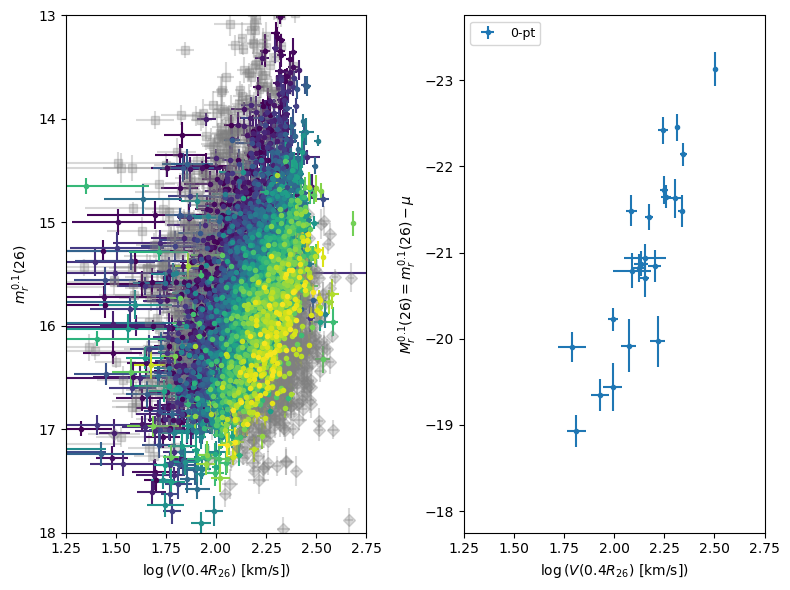

In [62]:
fig, axes = plt.subplots(1, 2, figsize=(8,6), sharex=True, tight_layout=True)

logV0 = 0

ax = axes[0] 

#-------------------------------------------------------------------------------
# Plot galaxies with failed cluster selections.
#-------------------------------------------------------------------------------
_zbin_ids = np.unique(rejtab['Z_BIN_IDX'])
markers = 'sDv^<>'
for j, _zbin_id in enumerate(_zbin_ids):
    select_zbin = np.isin(rejtab['Z_BIN_IDX'], _zbin_id)

    #- Store independent variable for each cluster
    logv = np.log10(rejtab['V_0p4R26'][select_zbin].data) - logV0
    logv_err = 0.434*rejtab['V_0p4R26_ERR'][select_zbin].data / rejtab['V_0p4R26'][select_zbin].data

    #- Store dependent variable for each cluster
    mr26 = rejtab['R_MAG_SB26_CORR'][select_zbin].data
    mr26_err = rejtab['R_MAG_SB26_ERR_CORR'][select_zbin].data

    if _zbin_id == 0:
        ax.errorbar(x=logv, y=mr26, xerr=logv_err, yerr=mr26_err, 
                    fmt=markers[j % 2], markersize=6, color='gray', alpha=0.3, 
                    label=f'z $\leq$ {zbins[_zbin_id]:.3f} (rej.)')
    else:
        ax.errorbar(x=logv, y=mr26, xerr=logv_err, yerr=mr26_err, 
                    fmt=markers[j % 2], markersize=6, color='gray', alpha=0.3, 
                    label=f'z > {zbins[_zbin_id-1]:.3f} (rej.)')
#-------------------------------------------------------------------------------
# Plot galaxies and clusters passing all selections.
#-------------------------------------------------------------------------------
_zbin_ids = np.unique(caltab['Z_BIN_IDX'])

plt.rcParams['axes.prop_cycle'] = plt.cycler('color', plt.cm.viridis(np.linspace(0,1,len(_zbin_ids)+1)))

for _zbin_id in _zbin_ids:
    select_zbin = np.isin(caltab['Z_BIN_IDX'], _zbin_id)

    #- Store independent variable for each cluster
    logv = np.log10(caltab['V_0p4R26'][select_zbin].data) - logV0
    logv_err = 0.434*caltab['V_0p4R26_ERR'][select_zbin].data / caltab['V_0p4R26'][select_zbin].data

    #- Store dependent variable for each cluster
    mr26 = caltab['R_MAG_SB26_CORR'][select_zbin].data
    mr26_err = caltab['R_MAG_SB26_ERR_CORR'][select_zbin].data
    
    ax.errorbar(x=logv, y=mr26, xerr=logv_err, yerr=mr26_err, fmt='.', 
                label=f'{zbins[_zbin_id-1]:.3f}-{zbins[_zbin_id]:.3f}')
#-------------------------------------------------------------------------------

ax.set(xlim=[1.25, 2.75],
       xlabel=r'$\log{(V(0.4R_{26})~[\mathrm{km/s}]}$)',
       ylim=[18, 13],
       ylabel=r'$m_r^{0.1} (26)$')
# ax.legend(loc='upper left', fontsize=9)

#- Plot the 0-pt calibrators
ax = axes[1]

logv = np.log10(zeroptab['V_0p4R26'].data) - logV0
logv_err = 0.434*zeroptab['V_0p4R26_ERR'].data / zeroptab['V_0p4R26'].data
mr26 = zeroptab['R_ABSMAG_SB26'].data
mr26_err = zeroptab['R_ABSMAG_SB26_ERR'].data

ax.errorbar(x=logv, y=mr26, xerr=logv_err, yerr=mr26_err, fmt='.', color='tab:blue', label='0-pt')
ax.set(xlim=[1.25, 2.75],
       xlabel=r'$\log{(V(0.4R_{26})~[\mathrm{km/s}]}$)',
       ylim=[-17.75, -23.75],
       ylabel=r'$M_r^{0.1}(26) = m_r^{0.1}(26) - \mu$')
ax.legend(loc='upper left', fontsize=9);

# fig.savefig('../../Figures/Y1/TF_Y1_cluster_calibration_0pt_binaryMLupdated_20241203.png', dpi=150);

# Apply the Joint TFR Fit

In [63]:
#- Extract successful clusters
_zbin_ids = np.unique(caltab['Z_BIN_IDX'])
m = len(_zbin_ids)

#- Pack the results into arrays data and cov.
logV, logV_err = [], []
mag, mag_err = [], []

logV0 = np.median(np.concatenate([np.log10(caltab['V_0p4R26']), 
                                  np.log10(zeroptab['V_0p4R26'])]))
print('logV0 =', logV0)

# Start with the zero-point calibrators
logV.append(np.log10(zeroptab['V_0p4R26']) - logV0)
logV_err.append(0.434*zeroptab['V_0p4R26_ERR'] / zeroptab['V_0p4R26'])
mag.append(zeroptab['R_ABSMAG_SB26'])
mag_err.append(zeroptab['R_ABSMAG_SB26_ERR'])

#- Loop over the redshift bins
for k, _zbin_id in enumerate(_zbin_ids):
    select_zbin = np.isin(caltab['Z_BIN_IDX'], _zbin_id)
    logV.append(np.log10(caltab['V_0p4R26'][select_zbin]) - logV0)
    logV_err.append(0.434*caltab['V_0p4R26_ERR'][select_zbin] / caltab['V_0p4R26'][select_zbin])
    mag.append(caltab['R_MAG_SB26_CORR'][select_zbin])
    mag_err.append(caltab['R_MAG_SB26_ERR_CORR'][select_zbin])

logV0 = 2.17207961088939


## Multiline Fit using HyperFit

In [64]:
bounds = [[-20, 0]]                    # Bounds on a (slope)
bounds += [(-40,0)] + m*[(-20, 20)]    # Bounds on b (intercepts: 0-pt + clusters)
bounds += [(0,5)]                      # Bounds on sigma

results = hyperfit_line_multi(logV, mag, logV_err, mag_err, bounds, scatter=1)

a, b, sig_tfr, cov_tfr, tfr_mcmc_samples, hf_tfr = results

             message: Optimization terminated successfully.
             success: True
                 fun: -572952.356041557
                   x: [-6.284e+00 -2.111e+01 ...  1.686e+01  4.621e-01]
                 nit: 752
                nfev: 825719
          population: [[-6.283e+00 -2.110e+01 ...  1.686e+01  4.622e-01]
                       [-6.281e+00 -2.111e+01 ...  1.686e+01  4.622e-01]
                       ...
                       [-6.279e+00 -2.110e+01 ...  1.687e+01  4.623e-01]
                       [-6.283e+00 -2.110e+01 ...  1.686e+01  4.622e-01]]
 population_energies: [-5.730e+05 -5.729e+05 ... -5.729e+05 -5.729e+05]
                 jac: [-2.445e-01  4.773e-01 ...  3.958e-01 -1.723e+00]
Ndim: 73 71


100%|███████████████████████████████████████| 1000/1000 [05:26<00:00,  3.06it/s]


Niterations/Max Iterations:  1000 / 100000
Integrated ACT/Min Convergence Iterations:  [103.36878239 100.46949271  94.56762477  94.03297231  91.82344996
  96.91406258  92.86745131  95.3522481   98.92862587  93.35376359
  98.09270714  94.34305601  93.23488543  92.10740481  94.7285468
  97.86311671  92.82967221  94.7731096   92.89394509  95.67274078
  96.06785315  94.64766655  93.72520946  98.59755121  95.64605566
  97.50274703  98.91326248  97.37167759  94.72367097  89.76558116
  95.73432841  96.18027916  94.19315884  98.44186914  98.39918828
  96.45519396  98.18322515  94.67342797  96.73597513  96.31880578
  95.17055348  93.76828043  93.07514438  90.03654882 100.74277106
  96.83826111  97.51992976  97.41996546  95.93242998  91.45725599
  97.6157232   94.12452793  95.78320031  94.79927     94.54530827
  90.71552397  94.15581939  98.2207771   97.48366107  94.08993492
  96.86485034  99.92866229  97.53649797  99.01570666 100.27176717
 100.52564343  96.14288293 102.43649836  97.95590914 102

100%|███████████████████████████████████████| 1000/1000 [05:25<00:00,  3.07it/s]


Niterations/Max Iterations:  2000 / 100000
Integrated ACT/Min Convergence Iterations:  [147.66785114 157.54039259 139.27964356 142.16167396 146.39258688
 144.18949408 138.73033096 148.13082732 142.7884487  142.32436587
 143.50760258 139.1361264  139.39134081 144.7980986  139.23237135
 145.36577375 143.70505075 141.1592061  142.5678317  142.95180776
 136.46108975 144.77417497 144.58518454 139.07498159 142.36110993
 140.47166746 140.0667405  140.34461278 140.7803943  142.77642081
 148.86889274 147.76851099 143.51935724 139.55555183 145.88990126
 141.27672629 133.08991744 140.82258377 142.98034562 151.91509179
 139.99838365 148.35019617 142.6939327  146.65292321 146.29040395
 144.27475833 144.09611278 148.84940531 143.92856451 142.8676691
 136.56275376 141.98157871 142.45056348 139.78747738 144.37192696
 133.52257322 147.37086297 148.09976437 140.74725008 146.68457764
 144.73649911 148.848008   150.31114838 145.8258467  150.51426698
 140.78705074 151.04859977 153.65083337 152.55192215 151

100%|███████████████████████████████████████| 1000/1000 [05:25<00:00,  3.07it/s]


Niterations/Max Iterations:  3000 / 100000
Integrated ACT/Min Convergence Iterations:  [188.49695158 183.95306847 184.15616929 184.37375023 180.20170145
 181.73736173 178.49056504 178.9456844  179.69126183 187.98841508
 175.5658796  185.25089689 178.65691794 181.38592097 186.88398008
 185.83768795 189.97544817 185.92519754 180.33762388 180.94187188
 176.33955801 180.53505969 177.57147783 174.89757687 177.34792167
 184.79221744 173.25257852 187.23320384 178.34000835 177.77586683
 181.55133338 173.78683031 181.59131299 177.96357403 185.30749428
 180.62987822 180.69413427 182.90783372 179.82742817 182.02312799
 174.84281705 183.36727889 177.5973668  183.83843451 183.39475881
 184.19458935 185.25462754 188.06259011 181.21115536 182.58458102
 184.70369559 178.91463208 187.57628957 188.44994864 188.44623623
 172.93619888 186.9995433  184.27411022 182.6125337  185.17226387
 184.17242072 184.67183486 184.06520455 189.66273325 189.13742357
 181.50006303 186.49013719 189.66368923 194.87306606 18

100%|███████████████████████████████████████| 1000/1000 [14:21<00:00,  1.16it/s]


Niterations/Max Iterations:  4000 / 100000
Integrated ACT/Min Convergence Iterations:  [206.55204017 209.61950712 200.30610331 196.92126829 204.50502358
 209.25347345 195.42191777 198.12864032 200.70894311 199.99201548
 205.14509802 201.3444642  188.96417886 192.32763724 205.31131579
 207.70272284 212.49955615 203.97343107 195.56701029 194.37516074
 192.33727824 193.45757224 201.67824103 195.17536    199.59820856
 201.66899611 196.31389379 196.92936785 191.08671339 203.1089124
 201.0892143  204.59439897 207.17723924 192.94355647 207.41641331
 196.15980296 192.02997986 204.44677472 192.56712876 199.87512374
 210.32077882 204.72480486 197.34335836 199.54961479 204.99141406
 202.60204812 208.03300434 203.04709936 202.1700803  203.26233508
 205.8896624  194.52708667 195.43357797 201.77275998 202.88561056
 182.51304677 210.15615408 200.43840786 204.75038156 205.21130892
 199.83133631 204.53762472 208.33147532 208.96416842 206.11775458
 206.48583671 207.35445076 215.40609193 209.2659442  208

100%|███████████████████████████████████████| 1000/1000 [05:24<00:00,  3.08it/s]


Niterations/Max Iterations:  5000 / 100000
Integrated ACT/Min Convergence Iterations:  [244.01799338 231.84145621 238.56195112 237.24100972 226.73327631
 240.22395586 231.02983318 231.79424359 229.84768144 229.09892539
 246.79182168 243.94233202 220.97148814 236.59874101 235.14942774
 235.8582467  244.52022871 227.80699856 225.4581882  238.10249831
 223.16052299 242.6012197  238.11698554 228.97169601 242.10854295
 230.94219171 239.5009835  229.87463503 230.67033535 236.84294566
 242.27434071 234.43106016 238.98566699 226.9388411  238.66005491
 230.33681398 227.2834361  232.10419663 230.89188936 230.83281675
 237.70686726 222.13051421 230.0255357  234.34066276 243.56095742
 227.8080809  238.07927001 227.55447127 227.66376644 246.09552879
 244.9857712  234.71747823 233.15343189 235.36085177 243.05796065
 227.85061278 231.73880353 244.08187159 231.09215293 231.65216252
 237.80681491 238.79996529 243.58658614 237.37223281 242.06164211
 247.18658404 245.63608136 224.92814553 236.30541669 22

100%|███████████████████████████████████████| 1000/1000 [05:25<00:00,  3.08it/s]


Niterations/Max Iterations:  6000 / 100000
Integrated ACT/Min Convergence Iterations:  [251.38755515 256.46745524 244.39756577 245.35857062 243.07022279
 252.88976735 250.71653979 243.51783636 243.90460499 242.25294276
 248.97250651 253.49288689 242.92033749 255.11173136 242.49498028
 253.54621882 255.28112106 240.23509922 243.73592845 250.03411455
 238.36683641 252.78150455 256.79555786 245.74250826 241.98304299
 240.46322446 247.48154764 240.76380298 250.53556151 249.52208168
 251.36571206 246.84934286 257.16332626 245.66950913 252.58884779
 247.05663465 241.95925298 252.32314322 236.9577503  246.4991708
 243.32931244 244.21472368 258.83407695 241.45324982 267.090839
 244.69275589 251.02337476 247.59787957 249.44069441 242.95614393
 246.3060735  227.82789695 236.4373256  250.48622378 252.8045788
 243.82836718 247.84035032 250.27519152 249.19972071 244.23728952
 251.67918439 252.81132376 265.83477781 260.81340241 268.16661921
 254.15992454 254.07372291 237.62770238 245.82143979 247.85

100%|███████████████████████████████████████| 1000/1000 [05:24<00:00,  3.08it/s]


Niterations/Max Iterations:  7000 / 100000
Integrated ACT/Min Convergence Iterations:  [277.33006922 288.87638484 273.99457015 277.61902546 278.42844735
 279.56119186 269.69268246 268.32213512 271.01798231 273.78766366
 281.25458487 269.18777541 275.13013529 275.78211368 262.56360341
 284.87213501 274.92344468 279.77830464 271.22075648 265.98827451
 264.08390084 273.32731623 275.62153552 266.78416603 268.73553088
 266.24772158 269.41059183 270.17769614 283.59349223 259.36105768
 282.70206394 270.79007221 280.07801088 260.71313613 280.48564063
 264.51796307 256.37673034 270.40497784 272.92744564 292.11268123
 277.06635995 279.36906178 281.40165687 271.38495429 287.08532682
 278.43775019 267.68238797 280.72486617 276.37338952 263.19370174
 274.28681043 270.05461638 269.19371678 274.65896421 272.93494497
 270.56103084 275.84310681 270.37819493 278.25367066 269.84955027
 271.10295957 283.24954019 295.29280263 285.57599727 272.3049493
 281.18690252 264.19548709 276.66573372 285.4362112  263

100%|███████████████████████████████████████| 1000/1000 [05:24<00:00,  3.08it/s]


Niterations/Max Iterations:  8000 / 100000
Integrated ACT/Min Convergence Iterations:  [289.73032956 303.32912456 282.93981659 286.6331492  295.77812896
 290.69245274 277.73097751 268.61127866 272.18295005 280.27272603
 293.70162326 281.39145862 267.67992697 283.2256491  268.82107692
 292.72756556 276.76933967 290.35582185 291.5907069  271.75155767
 277.3099868  278.39250492 276.4059748  283.05747333 277.04247886
 281.10872472 277.69191112 283.06279655 272.29179299 270.24709742
 284.97845271 270.17844028 282.9011823  268.22436446 275.45566883
 272.39292855 260.53472399 275.60873971 276.11611447 284.95094082
 280.26976844 272.62318876 282.53481533 287.79177704 288.14729432
 289.37226175 273.06551289 290.39310931 291.06446726 271.27421706
 281.09980563 275.85148549 276.56270434 287.42142715 286.17589314
 280.63920257 278.20935728 276.97510293 296.97614658 271.92697089
 289.89865    284.10801589 295.89572958 281.59470345 283.19995316
 284.88827417 270.62028945 283.87445109 299.14003771 27

100%|███████████████████████████████████████| 1000/1000 [05:25<00:00,  3.07it/s]


Niterations/Max Iterations:  9000 / 100000
Integrated ACT/Min Convergence Iterations:  [325.50527794 341.77650926 312.51773719 311.2796761  312.71523575
 310.96528269 292.45648067 292.22109147 293.75720814 308.1630898
 322.17470043 299.20056496 288.30513618 302.74001472 307.6061456
 296.87555369 301.72412845 310.63436548 313.86446495 291.03920379
 291.37786666 305.04761714 301.30612444 290.28259093 302.43067778
 310.71306759 307.65465618 303.46859079 298.77373953 308.15172028
 296.04087023 298.81451398 308.46361039 299.85235361 296.72660622
 302.12680916 270.7905303  309.30943457 298.95518044 312.96429808
 304.70146493 295.56322308 296.48331402 298.38113388 314.51957957
 300.51604003 317.74276259 296.73526822 303.86875099 285.52488439
 298.47058111 301.7605236  305.28225685 306.39962124 309.05767438
 301.75388003 295.08351407 297.4654716  318.53903243 297.49830251
 316.64795525 320.26102976 303.99685597 301.27525467 307.54841048
 311.12570381 295.73329352 308.13601339 322.99736082 309.

100%|███████████████████████████████████████| 1000/1000 [53:14<00:00,  3.19s/it]


Niterations/Max Iterations:  10000 / 100000
Integrated ACT/Min Convergence Iterations:  [326.11100843 333.88061162 319.64680408 312.23957673 304.11410303
 309.4923019  298.92137412 319.21314204 293.09708626 311.90440505
 311.27408069 300.38386012 287.76638693 308.56698704 319.43233186
 312.32516495 305.60842939 306.15059759 315.41875043 298.25330479
 287.56491324 303.28260136 308.87558736 296.74249536 300.12491903
 299.92057338 319.17362802 306.35765138 306.05152503 327.20325383
 298.51347607 307.24607026 300.66615968 301.40133163 295.72120635
 315.34696263 272.64055544 299.58620074 295.43708153 316.24696625
 316.94690132 306.19793229 302.90958109 311.03511762 306.02937409
 299.11060866 318.08598831 308.69556011 316.06638948 293.53662838
 309.93409821 306.18042638 308.11372258 314.47480689 319.42806959
 298.19410358 284.80670248 306.36843057 322.18895999 306.14509536
 322.78816685 321.00232475 311.61244736 310.47363881 314.81798404
 307.10562573 310.97758814 297.20663529 340.33110869 3

100%|███████████████████████████████████████| 1000/1000 [21:28<00:00,  1.29s/it]


Niterations/Max Iterations:  11000 / 100000
Integrated ACT/Min Convergence Iterations:  [343.78037747 336.37015728 336.18455859 327.35384986 310.95741569
 338.3785667  320.77523766 349.16108369 322.31506231 320.62891952
 332.14477134 315.67138382 313.93053872 314.1101808  332.64954752
 337.77988382 319.17230078 325.54039127 333.04379629 328.46104948
 307.7853564  307.59477239 333.33614282 317.04490432 330.8429327
 318.29382412 330.09393867 317.75705739 325.86854604 338.44841039
 318.0441094  331.41113294 316.17593235 313.41519308 330.17146965
 333.89701943 302.37910147 313.71579646 308.41825862 334.02902253
 343.97378169 318.55728427 318.49077775 339.9600769  310.51697914
 313.39954254 337.49304404 330.55221735 335.54916606 317.47984763
 337.59117692 334.61711679 325.69453177 335.0830333  341.37788686
 303.33974213 297.17378325 332.50813729 325.74554852 332.69851499
 346.49487187 330.82874582 332.11074328 334.49792932 330.6122415
 329.49049068 345.32878892 321.53936229 360.32475806 346

100%|███████████████████████████████████████| 1000/1000 [21:22<00:00,  1.28s/it]


Niterations/Max Iterations:  12000 / 100000
Integrated ACT/Min Convergence Iterations:  [348.62976562 331.66703977 347.92347023 336.27888226 310.07057443
 327.71210243 334.54699201 355.72724465 328.91631697 324.95155545
 335.47289768 333.19795386 314.06646556 319.3400299  323.25142479
 343.72006556 319.28350777 332.84812549 333.77853973 323.13227215
 319.53774801 325.67612016 336.14451122 319.57618523 334.65646304
 328.18821044 330.06746083 328.7421636  325.37544796 340.47979579
 327.18209379 320.46874784 329.37535499 305.75953066 332.73904756
 337.90495204 309.48583256 329.25796776 310.78659875 341.47126669
 338.73627522 324.85004944 320.90894546 340.29174323 316.3260638
 308.32353452 335.50747941 335.50242726 332.23782589 309.33729486
 337.7630475  322.86589757 320.98721208 330.28178149 345.70108538
 300.54784928 301.29594918 330.20840532 323.61987836 333.32261675
 350.96009035 328.16697579 333.89010912 337.40113669 344.82004363
 335.79079929 349.08489329 339.9095759  353.99689566 34

100%|███████████████████████████████████████| 1000/1000 [14:02<00:00,  1.19it/s]


Niterations/Max Iterations:  13000 / 100000
Integrated ACT/Min Convergence Iterations:  [351.68883981 353.00504107 362.70567067 344.09642943 328.35935299
 331.58440931 353.98287919 375.74079305 337.33987154 333.06284789
 355.52161367 360.45344007 321.84068889 337.27301472 338.5593305
 367.58873378 349.05786781 363.71333407 340.52261719 336.88545805
 329.4110453  342.13190854 348.66868451 340.55069994 357.27723641
 340.8754101  343.25832574 347.72046632 338.94611502 355.29148242
 329.95145375 331.28330372 348.02582002 332.50440536 355.18751531
 353.26456743 328.64938817 347.53818395 324.96376545 349.21814207
 360.45141097 348.19464588 340.98997304 372.92906382 350.92389806
 329.90602947 350.7950787  351.98516684 339.98483531 321.45591228
 341.86777646 335.6822501  334.80313496 340.25552388 368.83881803
 325.78425835 310.32276875 361.61208553 334.09400917 346.46522746
 372.80920841 347.64555983 351.84631769 343.0881514  385.14819121
 360.52123406 358.53661169 365.10217777 356.68834326 35

100%|███████████████████████████████████████| 1000/1000 [05:23<00:00,  3.09it/s]


Niterations/Max Iterations:  14000 / 100000
Integrated ACT/Min Convergence Iterations:  [372.78239731 360.72456958 361.24461461 342.10820651 335.1762182
 335.71363684 367.89512602 373.12663424 339.76277217 335.57455644
 365.07476108 360.23310597 326.60459315 340.31877739 343.36785927
 370.97227892 346.31808348 358.07764052 349.85981019 339.30551278
 330.24193399 347.9406973  349.53331664 339.86803226 352.57372366
 341.5053357  339.49498069 344.55292201 339.27775751 349.89857014
 335.72474786 334.26630022 346.19815903 331.34847985 359.72938108
 355.39067331 339.53848265 352.30944831 329.64361861 357.7183611
 368.73005201 359.74227667 344.16653508 369.21639614 361.64588077
 320.16117997 344.82196973 354.93281628 344.65977922 313.5013894
 336.41673857 342.49935807 327.15158397 342.97240553 371.18137994
 325.52656986 311.90937503 364.51368786 336.55446999 366.25632643
 371.02803971 359.53496192 352.56479192 358.54660552 376.09117934
 360.15838199 357.99595866 368.75584229 354.2846637  357.

100%|███████████████████████████████████████| 1000/1000 [45:25<00:00,  2.73s/it]


Niterations/Max Iterations:  15000 / 100000
Integrated ACT/Min Convergence Iterations:  [388.02299598 374.62176254 379.99751742 355.1378089  355.61475698
 353.33774769 380.52928901 386.28230156 361.78143011 350.47394686
 399.44070188 367.1579776  350.99926738 356.52401959 367.16574409
 367.85174998 371.1587572  373.76206539 351.89051418 359.38854492
 338.3302921  366.36306356 364.70227262 349.13170074 367.77607461
 357.01978811 355.86957353 352.59886479 348.06469147 361.29197455
 354.83340634 343.28835626 356.60587722 349.18616843 363.74524186
 358.87178596 344.31960667 374.70402475 345.64240001 369.66648466
 379.62162058 370.25994734 350.99818931 384.17128259 381.51428082
 340.84516896 358.14828083 361.38224092 349.73139532 338.34133598
 342.26968171 364.70639539 345.53818065 359.35338071 379.19937856
 351.62134701 342.27111921 365.54311518 356.1545567  381.3694288
 378.55632103 375.65635568 370.66276326 375.82047678 378.58527401
 386.67981877 378.37354921 397.35452353 364.67312144 37

100%|███████████████████████████████████████| 1000/1000 [05:22<00:00,  3.10it/s]


Niterations/Max Iterations:  16000 / 100000
Integrated ACT/Min Convergence Iterations:  [379.99444574 378.18769989 382.54545518 357.29396117 347.56049779
 348.93619225 377.39034851 392.27552566 362.92907474 350.92276467
 410.85412423 379.33224389 340.54971504 355.86036337 371.90784072
 368.99723562 386.34897034 369.56719141 362.97577471 358.61723852
 329.58920215 368.10110346 360.92968856 346.15860969 367.03059956
 349.08344783 357.10081627 363.59208132 347.3027373  363.74972427
 365.78175724 348.3773036  354.53147696 354.45488334 375.33978931
 362.52880664 349.10121835 361.72693708 364.62410839 374.73350202
 373.35130678 382.08500089 352.58586235 374.82453209 390.7099837
 341.50809537 363.2624558  361.66275373 347.62551371 330.35721296
 344.70688038 368.11995963 347.0506669  367.12391833 383.65265988
 356.11130872 347.75637053 371.39570216 370.97159806 386.04670979
 389.41748685 369.55992617 375.55285167 377.3733848  363.79574713
 383.96605753 372.75920016 388.38610384 371.55943053 37

100%|███████████████████████████████████████| 1000/1000 [05:23<00:00,  3.10it/s]


Niterations/Max Iterations:  17000 / 100000
Integrated ACT/Min Convergence Iterations:  [397.74244714 394.59266795 392.22628676 375.1651711  351.00909702
 360.11638219 380.93254157 405.92592415 381.16999519 352.5553132
 415.11345452 413.31283022 347.79704327 369.93104428 374.56153636
 379.30377371 416.15074831 374.97522547 378.09818781 378.32649604
 342.0891279  375.57641116 381.27956975 376.72064987 377.98236052
 366.7591748  372.18868255 374.17341405 363.79499707 384.95337477
 380.219029   358.66927024 361.54774479 371.79315759 381.63671093
 378.2419422  358.38534483 369.32869576 371.16259496 388.77037434
 384.03830678 405.03165885 365.58900187 390.5153863  410.68535692
 358.4827493  385.19488514 379.91862508 364.16211346 343.14896533
 357.39309401 386.2340972  375.10748293 391.43477259 388.97267092
 372.24746395 370.38227159 381.98280153 392.30123775 402.23428776
 402.78105702 374.75126621 372.5758323  390.67614809 369.19909736
 401.76776387 383.03499599 396.98243913 395.56926623 39

100%|███████████████████████████████████████| 1000/1000 [05:23<00:00,  3.09it/s]


Niterations/Max Iterations:  18000 / 100000
Integrated ACT/Min Convergence Iterations:  [394.79729328 393.01512533 395.91001351 372.58618774 348.08868845
 359.70893232 378.0020054  410.46877528 380.28150458 356.63431562
 426.19582433 427.76877955 351.15819559 367.70376662 375.95509847
 398.77639517 421.4398928  377.34664609 381.99674064 375.98231343
 348.38692244 368.68486393 382.9044539  378.58481889 383.34087826
 361.96827913 374.10318772 374.35092191 361.96670705 390.37907742
 382.18658962 357.42303617 380.12717916 369.09283092 376.12078252
 386.74547468 360.16116348 368.6959586  376.69684151 386.2033118
 387.34346655 386.10980056 379.79561443 391.77383012 404.06383044
 355.71300022 381.72191989 390.38839443 378.39844058 347.58074665
 362.78600531 389.7237537  381.10407085 383.990801   391.71856592
 378.25336769 364.02313429 389.5198978  389.40019199 405.380044
 405.3524769  383.4669173  375.46607705 395.19204009 363.56159539
 403.95554817 385.55120055 388.01219495 408.31283946 404.

100%|███████████████████████████████████████| 1000/1000 [05:23<00:00,  3.09it/s]


Niterations/Max Iterations:  19000 / 100000
Integrated ACT/Min Convergence Iterations:  [413.63399141 411.97257522 402.00752621 386.73227877 354.90490843
 379.1372641  393.25783274 429.73456885 411.20186711 369.93300553
 428.25040891 439.21259591 369.69428083 386.35496369 378.7669346
 414.72697269 434.94620987 396.57013884 396.50440709 396.75003441
 358.34699235 380.6358365  391.57929723 383.78550127 404.14332498
 383.55679687 381.43569046 383.28155676 373.78529826 391.71943823
 403.76594632 379.27128094 393.65564448 379.95707567 385.32729066
 404.16389587 371.72742462 396.32510882 392.96624172 392.31994777
 406.25901503 403.78774176 377.64737746 409.33756193 403.50688753
 356.93701326 405.38659446 399.7137511  393.2845613  358.22711471
 381.33493981 394.39331723 392.10169366 408.99110212 395.52919586
 393.51564178 380.4310255  408.15866923 403.79488553 407.92814682
 429.81476716 401.75166416 380.92861314 392.74983884 383.42149593
 427.98464802 411.31692537 401.99668962 418.78308839 43

100%|███████████████████████████████████████| 1000/1000 [05:23<00:00,  3.09it/s]


Niterations/Max Iterations:  20000 / 100000
Integrated ACT/Min Convergence Iterations:  [397.70282249 407.55781596 391.66777433 396.99311893 350.87478353
 380.67746874 397.4844823  425.53317748 405.39048744 373.14024291
 415.88453607 430.53294416 363.88637335 384.75138715 384.93943554
 409.37625028 435.66557573 401.76913072 409.62494435 397.55383887
 366.78573253 396.97029073 398.59045573 389.73631746 401.08513758
 382.35391963 378.93070175 377.4922622  373.91148678 391.19867845
 397.57560574 382.16273424 414.16277993 384.95996359 391.18972884
 397.73804179 363.43531635 411.44952925 391.56447889 392.20516197
 395.39673312 392.89659892 363.4258578  422.63863296 398.44349969
 357.47344956 417.97777697 396.42056294 393.24579688 364.63635637
 389.5154297  402.64203329 412.18106823 412.41216615 393.76349223
 393.44373712 376.5431058  411.12385172 404.83082901 405.5419756
 433.75076373 396.55690053 393.93559841 393.5950936  401.39581055
 429.98965918 404.34428405 402.53669798 431.99966089 41

100%|███████████████████████████████████████| 1000/1000 [05:23<00:00,  3.09it/s]


Niterations/Max Iterations:  21000 / 100000
Integrated ACT/Min Convergence Iterations:  [402.13360866 412.58150047 407.44382338 416.36540962 368.88821279
 395.36465278 413.00068659 438.84445475 418.13126111 382.74493547
 417.57850356 441.98177691 370.70237855 399.1646496  405.5836543
 423.70634354 459.02227334 408.71354099 422.98131545 397.36874119
 369.97425361 415.48307881 414.33884213 410.06764546 402.74977262
 396.10827698 393.4272569  393.041176   378.86088678 395.1872874
 410.14239909 394.77136613 438.85322594 404.39967763 414.7612244
 412.51950766 375.42399486 427.62597009 411.43134574 408.36597198
 397.98753086 399.67883649 376.35730914 426.74901357 419.30810826
 372.73361706 427.11914582 406.0132505  408.07039303 382.18090935
 405.82516731 410.18182571 416.1326623  416.07845433 416.47006509
 405.99066146 388.1173995  431.94035922 425.74834624 429.82578571
 448.72585482 406.54100521 422.3696591  402.97488934 431.38832207
 442.56209537 403.72557534 407.90989137 438.83761874 420.

100%|███████████████████████████████████████| 1000/1000 [05:23<00:00,  3.09it/s]


Niterations/Max Iterations:  22000 / 100000
Integrated ACT/Min Convergence Iterations:  [405.78494587 416.00974855 406.22740826 414.33912295 377.78380317
 386.66571316 409.86962686 444.20166453 419.30237919 387.97923145
 407.93416    441.33215696 375.63301678 395.27384657 411.32096448
 419.39461971 445.3965063  408.60057198 426.77294707 406.82052383
 365.84965811 406.32504985 412.5982728  423.42480049 393.19944713
 389.7159639  392.61666017 404.38567545 383.53406982 403.96652425
 417.31278427 396.99898542 451.72579978 410.7961646  418.57513928
 414.7922741  376.73289025 422.73836325 410.58261061 414.03733062
 412.50561967 396.19759427 375.86082089 416.93169419 412.93514223
 375.1340481  424.35189309 405.03034078 411.77283003 377.74819327
 422.18131083 411.95000141 426.85797318 411.38110507 402.15965796
 397.32641236 395.02122291 423.54840695 426.42662518 417.73924094
 453.11982273 417.13422686 434.24527706 395.90787081 416.93539267
 444.22647785 400.02935416 401.21646503 431.5251176  4

100%|███████████████████████████████████████| 1000/1000 [05:23<00:00,  3.09it/s]


Niterations/Max Iterations:  23000 / 100000
Integrated ACT/Min Convergence Iterations:  [419.95029223 424.26924347 414.11324294 436.52657475 393.41836943
 395.93496498 415.53193325 453.94422295 435.55864881 401.80952702
 412.1414893  453.11210632 386.43552073 408.04041024 423.52946815
 429.77756265 436.81610768 419.55872485 434.57347427 415.05572852
 380.88066259 407.98114812 416.843829   431.47209487 405.75380352
 397.75031036 406.81203944 410.78994842 392.93368119 408.41449083
 422.52213305 409.82717292 461.72872818 424.79552013 426.54827836
 415.17660202 392.08029936 436.30530263 419.76479691 419.15671445
 428.2622132  416.55789402 391.9188404  424.59769557 432.06856198
 386.09472147 436.44201992 414.50844843 428.12566755 394.76502789
 445.19256888 432.01102685 444.79234112 423.95307628 406.85577312
 408.27928801 408.94424938 446.89678715 429.32980522 424.74130587
 447.9927895  429.46412679 454.16064804 413.18684757 430.0408461
 457.61441606 415.42699292 407.93889281 442.72309955 43

100%|███████████████████████████████████████| 1000/1000 [05:24<00:00,  3.09it/s]


Niterations/Max Iterations:  24000 / 100000
Integrated ACT/Min Convergence Iterations:  [419.18286436 423.76151415 407.53446718 430.59256569 383.38950312
 408.4952442  412.82741987 449.18774581 437.36453302 392.35264398
 407.58183869 448.53124533 388.24269275 401.61730949 415.2865734
 426.12635967 426.23264234 412.89254979 429.22928589 413.80861769
 384.26211273 419.60124088 409.99120726 425.50428094 413.27922528
 410.38537157 390.98942468 401.34776577 391.17684378 413.95954724
 430.72606724 416.12328158 464.77646192 425.45069963 425.30418324
 426.55087752 396.61398538 435.58132264 420.46336612 417.87679496
 437.96713119 420.12709622 395.94367873 429.68455774 424.68030288
 395.79807298 436.25860041 410.52544877 420.23579589 394.86082312
 440.48078131 434.49768614 435.38119175 430.96180924 408.06410434
 412.67041027 410.95762654 440.10461859 425.97283123 418.51171014
 449.79972049 423.2678874  441.15135586 408.96839123 420.34309907
 455.76641403 420.5777783  405.72773829 434.76599812 43

100%|███████████████████████████████████████| 1000/1000 [05:23<00:00,  3.09it/s]


Niterations/Max Iterations:  25000 / 100000
Integrated ACT/Min Convergence Iterations:  [424.56104802 438.99829214 419.40749772 433.38323985 393.5317256
 428.77503881 412.68848918 458.4653732  440.00362314 413.96720495
 424.90869344 461.52576604 405.00687515 405.58061912 423.4676559
 431.57546603 430.68057915 424.06140754 442.12781498 423.92544012
 406.39257932 431.75811609 413.15922221 428.37215581 424.46138531
 414.39712811 396.77449489 420.06360153 397.9614427  439.07670925
 435.84873706 427.22112018 465.58074392 436.62732655 427.26436137
 447.96287668 409.70895333 450.8888964  436.36425903 435.11858614
 449.01338714 431.06323221 415.3187868  444.30256184 421.68306244
 405.14670613 449.83090149 425.37611773 429.68293619 417.22013376
 449.57910107 453.14926002 436.16458087 437.23245032 428.27979928
 418.04547153 429.84916249 444.96521823 424.72814832 426.70622151
 451.59213313 432.70679957 443.20067439 441.78979688 433.54501972
 460.66326579 431.93393749 407.35467708 448.66953047 446

100%|███████████████████████████████████████| 1000/1000 [47:41<00:00,  2.86s/it]


Niterations/Max Iterations:  26000 / 100000
Integrated ACT/Min Convergence Iterations:  [430.59628051 442.99583995 409.81931079 438.5875568  392.1590557
 421.09867208 411.97941349 454.458997   433.03049233 415.18355786
 427.32833037 466.30959148 407.86039504 413.25156923 422.72036188
 429.18134273 422.36736581 426.15653056 446.43769074 415.94505903
 407.2001147  431.350758   413.00238388 433.46119498 416.01007267
 422.54287679 392.56567822 423.22778783 389.34889632 439.5192359
 432.23246977 426.18698859 462.20592516 433.11236977 434.50451085
 452.93825633 410.61618843 456.73797209 431.984511   436.86605063
 443.39551667 419.74477428 409.55378658 451.02830093 424.47948619
 407.81385273 448.67649539 423.77668865 431.9591203  420.37261776
 451.23925214 435.35418524 443.33700321 440.44453566 439.96034359
 416.28105546 427.65901382 442.79124276 424.96956284 421.13057517
 445.39385907 431.73938878 429.4212835  440.5854357  435.00718171
 454.16259662 430.61886972 407.53465556 439.59423256 447

In [65]:
temp_outfile = open('cov_ab_iron_jointTFR_varyV0-R26dwarfs_z0p1_zbins0p001_Anthony2_dVsys_KAD-20250804.pickle', 
                    'wb')
pickle.dump((cov_tfr, tfr_mcmc_samples, logV0), temp_outfile)
temp_outfile.close()

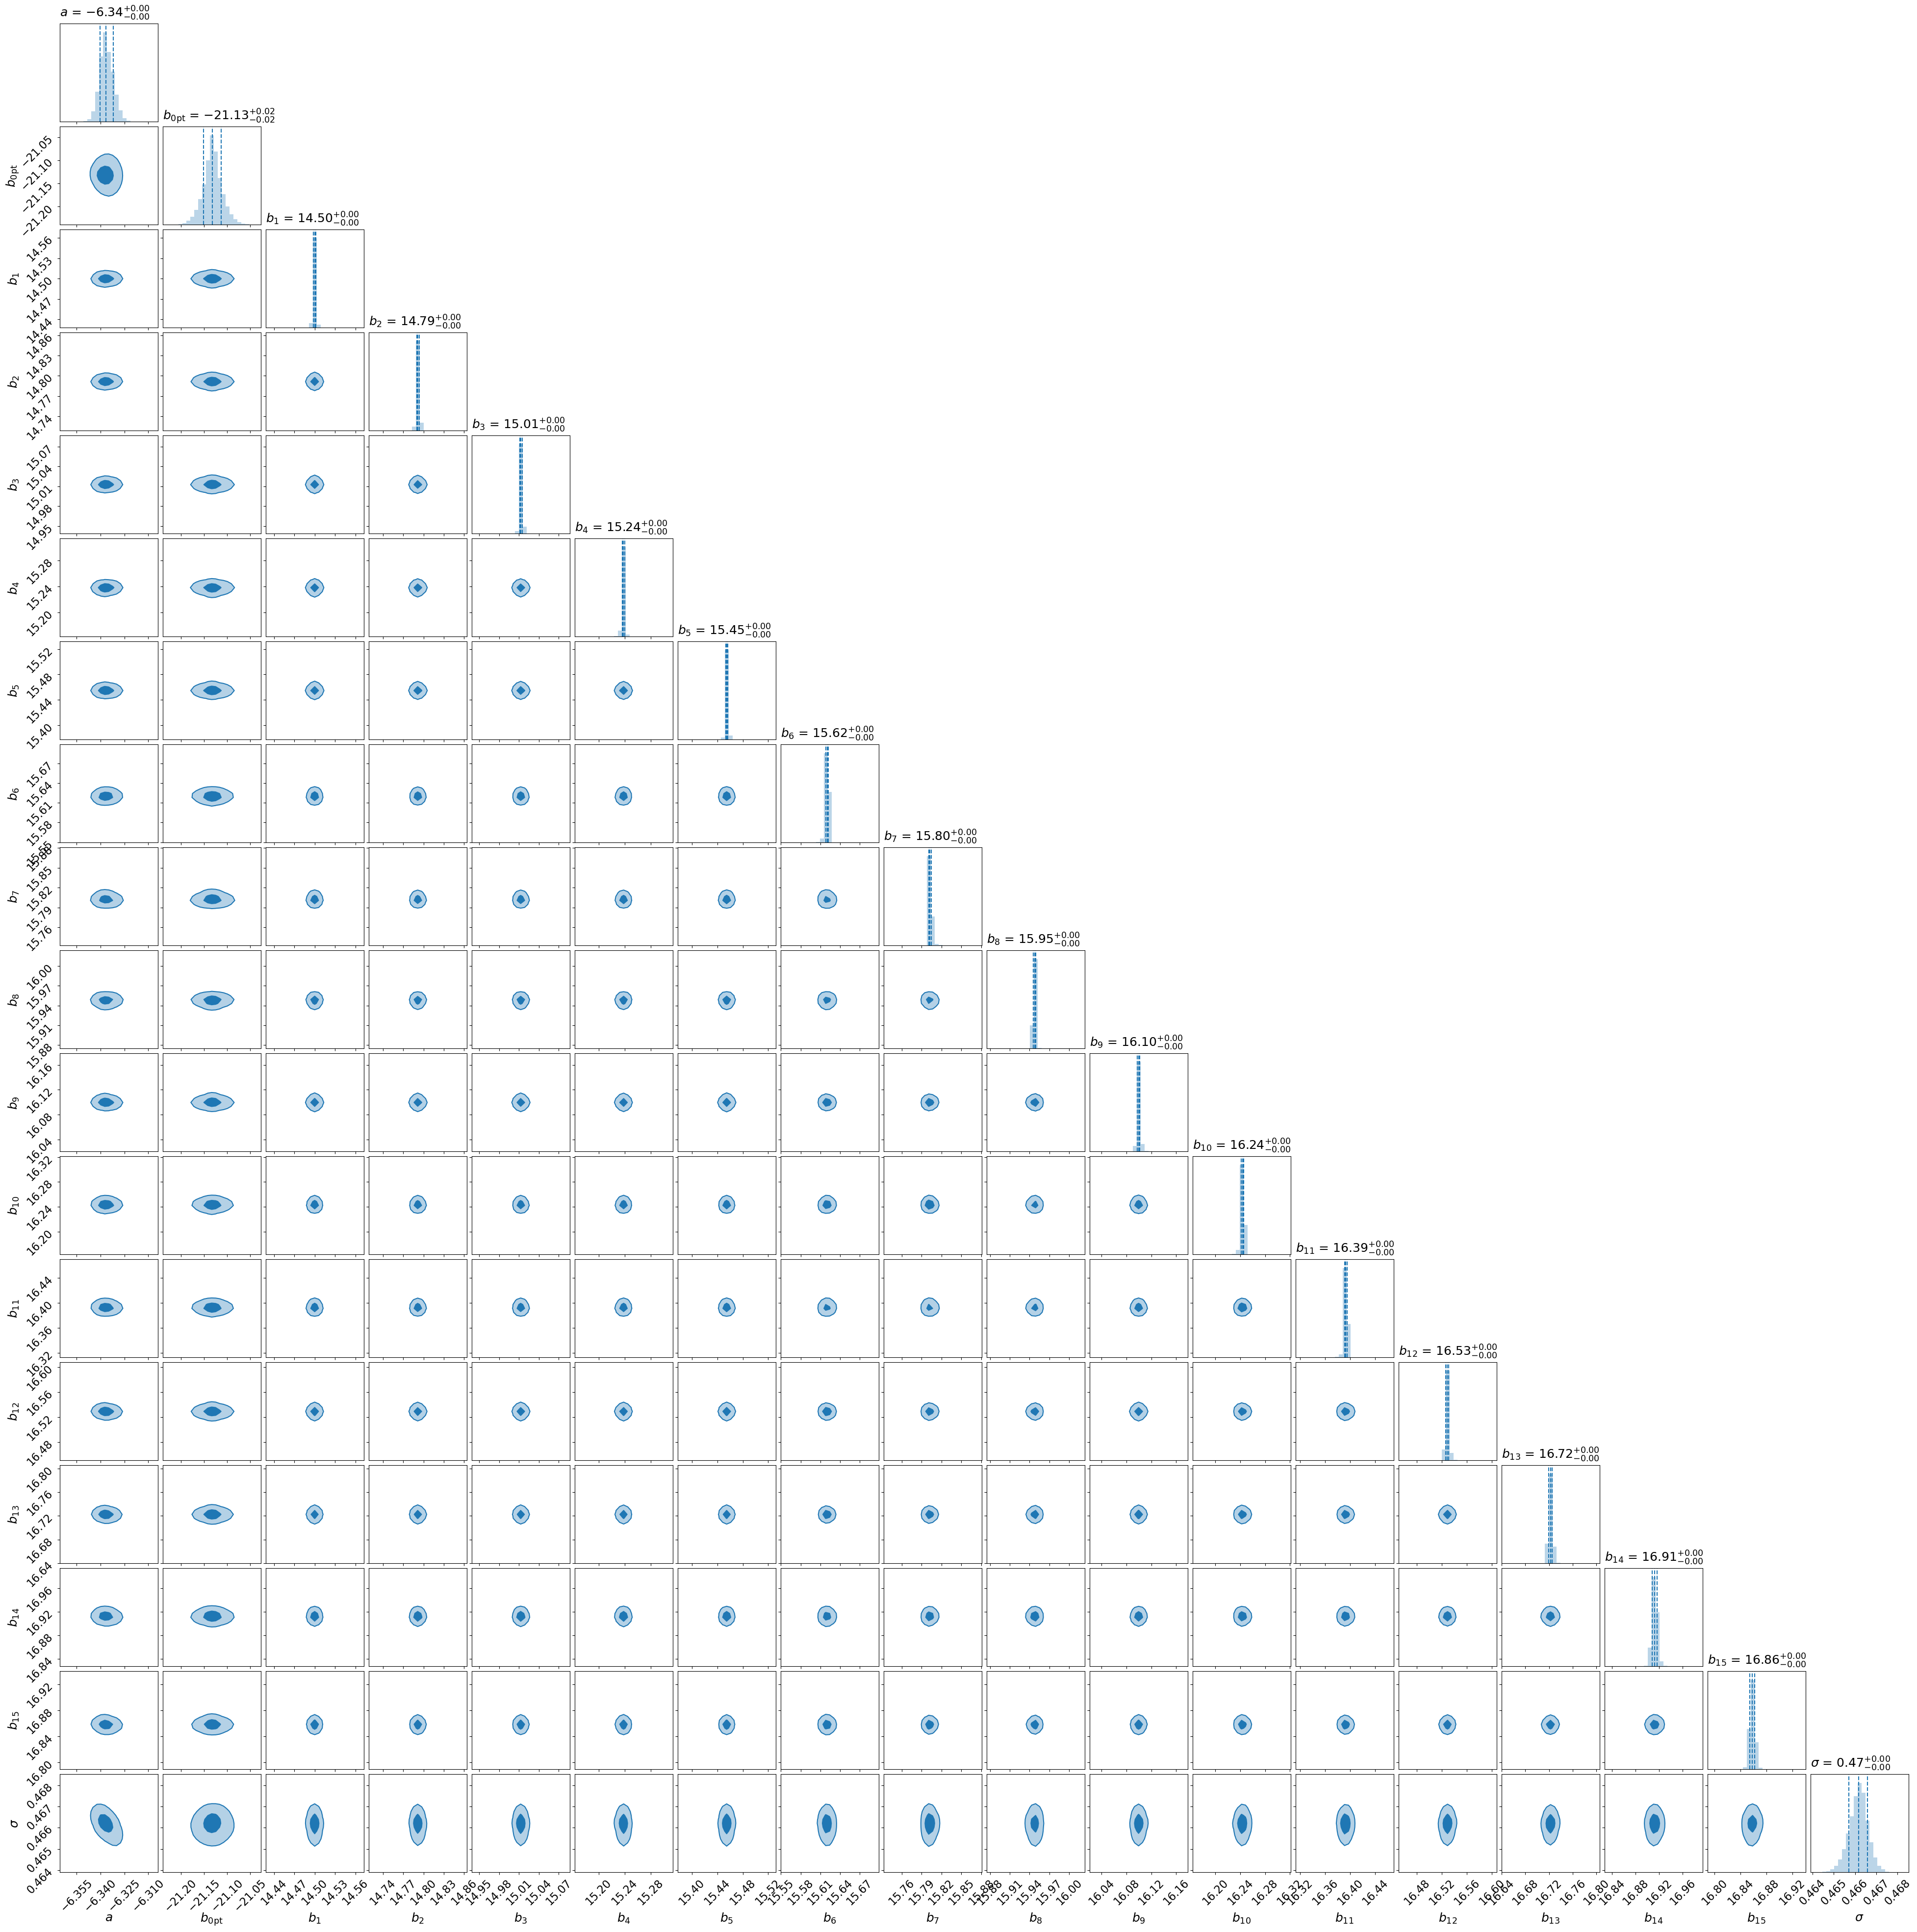

In [51]:
labels  = ['$a$']
labels += ['$b_{0\mathrm{pt}}$'] + [f'$b_{{ {k+1} }}$' for k in np.arange(m)]
labels += [r'$\sigma$'] #+ [rf'$\sigma_{k}$' for k in np.arange(m)]

fig = corner(tfr_mcmc_samples.T, bins=25, smooth=1,
#              range=[[1.9, 2.4], [0.75, 1.1], [0.1, 0.3]],   # Range for a, b, sigma. Adjust as needed.
             labels=labels,
             label_kwargs={'fontsize':18},
             labelpad=0.1,
             levels=(1-np.exp(-0.5), 1-np.exp(-2)),
             quantiles=[0.16, 0.5, 0.84],
             color='tab:blue',
             hist_kwargs={'histtype':'stepfilled', 'alpha':0.3},
             plot_datapoints=False,
             fill_contours=True,
             show_titles=True,
             title_kwargs={"fontsize": 18, 'loc':'left', 'pad':10});

for ax in fig.get_axes():
    ax.tick_params(axis='both', which='major', labelsize=16)

# fig.savefig('../../Figures/Y1/TF_Y1_cluster_calibration_binaryMLupdated_z0p1_Anthony2_weightsVmax-1_dVsys_corner0_20250717.png', 
#             dpi=150, 
#             facecolor='none');

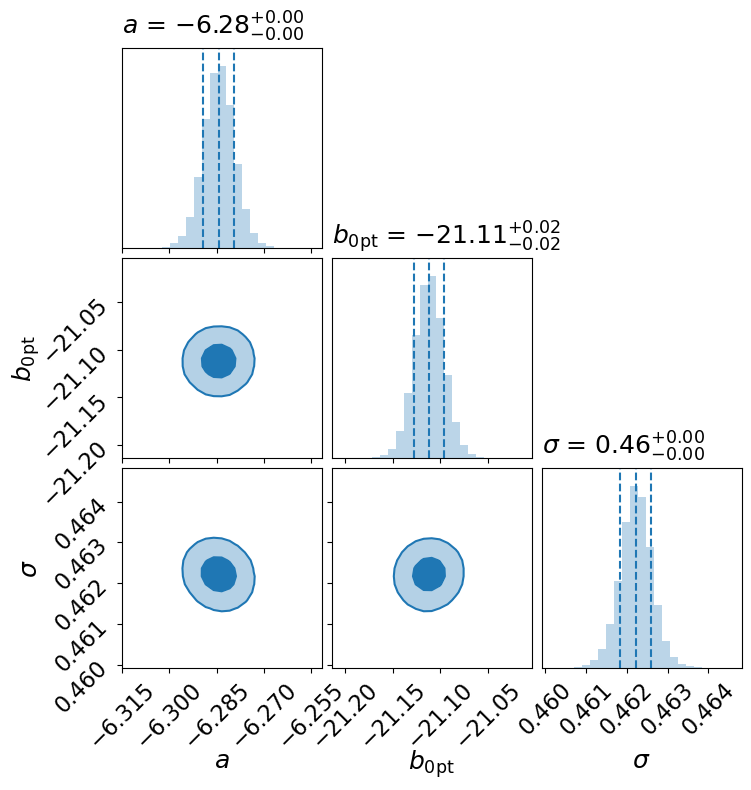

In [66]:
labels  = ['$a$']
labels += ['$b_{0\mathrm{pt}}$']
labels += [r'$\sigma$']

fig = corner(tfr_mcmc_samples[[0,1,-1],:].T, bins=25, smooth=1,
#              range=[[1.9, 2.4], [0.75, 1.1], [0.1, 0.3]],   # Range for a, b, sigma. Adjust as needed.
             labels=labels,
             label_kwargs={'fontsize':18},
             labelpad=0.1,
             levels=(1-np.exp(-0.5), 1-np.exp(-2)),
             quantiles=[0.16, 0.5, 0.84],
             color='tab:blue',
             hist_kwargs={'histtype':'stepfilled', 'alpha':0.3},
             plot_datapoints=False,
             fill_contours=True,
             show_titles=True,
             title_kwargs={"fontsize": 18, 'loc':'left', 'pad':10});

for ax in fig.get_axes():
    ax.tick_params(axis='both', which='major', labelsize=16)

# fig.savefig('../../Figures/Y1/TF_Y1_cluster_calibration_binaryMLupdated_z0p1_Anthony2_weightsVmax-1_dVsys_corner0_20250717.png', 
#             dpi=150, 
#             facecolor='none');

### Plot the HyperFit Results

In [67]:
sigma_mcmc = np.percentile(tfr_mcmc_samples[-1], [16., 50., 84.])
a_mcmc = np.percentile(tfr_mcmc_samples[0], [16., 50., 84])
b_mcmc = []
for k in range(1, m+2):
    b_mcmc.append(np.percentile(tfr_mcmc_samples[k], [16., 50., 84.]))
b_mcmc = np.asarray(b_mcmc)

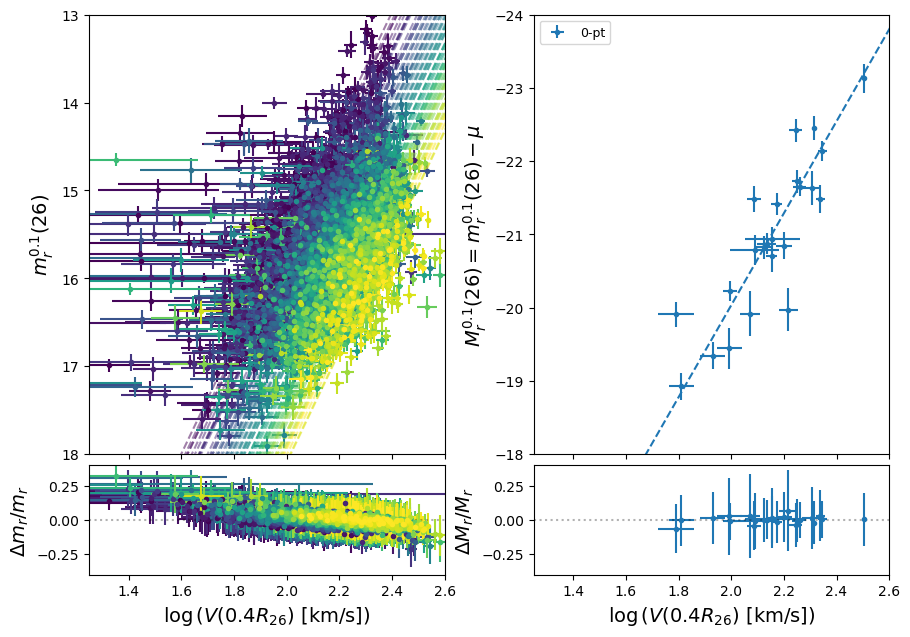

In [69]:
fig, axes = plt.subplots(2,2, figsize=(10,7), sharex=True,
                         gridspec_kw={'height_ratios':[4,1], 'hspace':0.04, 'wspace':0.25})

a_   = a_mcmc[1]
b0pt = b_mcmc[0,1]
b_   = b_mcmc[:,1][1:]

#- Plot redshift bins
ax = axes[0,0]

plt.rcParams['axes.prop_cycle'] = plt.cycler('color', plt.cm.viridis(np.linspace(0,1,m)))

_logv = np.arange(0, 3, 0.1) - logV0
for k in range(m):
    eb = ax.errorbar(x=logV[k+1] + logV0, y=mag[k+1], 
                     xerr=logV_err[k+1], yerr=mag_err[k+1],
                     fmt='.', 
                     label=f'{zbins[k]:.3f}-{zbins[k+1]:.3f}')

    ax.plot(_logv + logV0, a_*_logv + b_[k], color=eb[0].get_color(), ls='--', alpha=0.5)

ax.set(xlim=[1.25, 2.6],
       ylim=[18, 13])
ax.set_ylabel(r'$m_r^{0.1} (26)$', fontsize=14)
# ax.legend(loc='upper left', fontsize=9, ncol=2);

#- Plot calibrators
ax = axes[0,1]
eb = ax.errorbar(x=logV[0] + logV0, y=mag[0], xerr=logV_err[0], yerr=mag_err[0],
                 fmt='.', color='tab:blue', label=f'0-pt')

ax.plot(_logv + logV0, a_*_logv + b0pt, color=eb[0].get_color(), ls='--')#, label='fit')
ax.set(xlim=[1.25, 2.6],
       ylim=[-18, -24]
      )
ax.set_ylabel(r'$M_r^{0.1}(26) = m_r^{0.1}(26) - \mu$', fontsize=14)
ax.legend(loc='upper left', fontsize=9, ncol=2)

#- Plot residuals: clusters
ax = axes[1,0]

plt.rcParams['axes.prop_cycle'] = plt.cycler('color', plt.cm.viridis(np.linspace(0,1,m)))

for k in range(m):
    logv_obs = logV[k+1]
    m_obs = mag[k+1]
    m_exp = (a_*logv_obs + b_[k])
    eb = ax.errorbar(x=logv_obs + logV0, y=(m_exp-m_obs)/m_exp, 
                     xerr=logV_err[k+1], yerr=mag_err[k+1],
                     fmt='.')

ax.axhline(0, ls=':', color='k', alpha=0.3)

ax.set(xlim=[1.25, 2.6],
       ylim=[-0.4, 0.4])
ax.set_xlabel(r'$\log{(V(0.4R_{26})~[\mathrm{km/s}]}$)', fontsize=14)
ax.set_ylabel(r'$\Delta m_r/m_r$', fontsize=14)

#- Plot residuals: calibrators
ax = axes[1,1]

logv_obs = logV[0]
m_obs = mag[0]
m_exp = (a_*logv_obs + b0pt)

b = ax.errorbar(x=logv_obs + logV0, y=(m_exp-m_obs)/m_exp, 
                xerr=logV_err[0], yerr=mag_err[0],
                fmt='.', color='tab:blue')
ax.axhline(0, ls=':', color='k', alpha=0.3)

ax.set(xlim=[1.25, 2.6],
       ylim=[-0.4, 0.4])
ax.set_xlabel(r'$\log{(V(0.4R_{26})~[\mathrm{km/s}]}$)', fontsize=14)
ax.set_ylabel(r'$\Delta M_r/M_r$', fontsize=14)

fig.subplots_adjust(left=0.1, bottom=0.1, top=0.9, right=0.9);

# fig.savefig('../../Figures/Y1/TF_Y1_cluster_calibration_0pt_binaryMLupdated_z0p1_Anthony2_weightsVmax-1_dVsys_fit0_20250717.png', 
#             dpi=150, 
#             facecolor='none')

In [70]:
print(f'slope (alpha): {-a_/2.5:.2f} +/- {np.sqrt(cov_tfr[0,0])/2.5:.3f}')

slope (alpha): 2.51 +/- 0.002


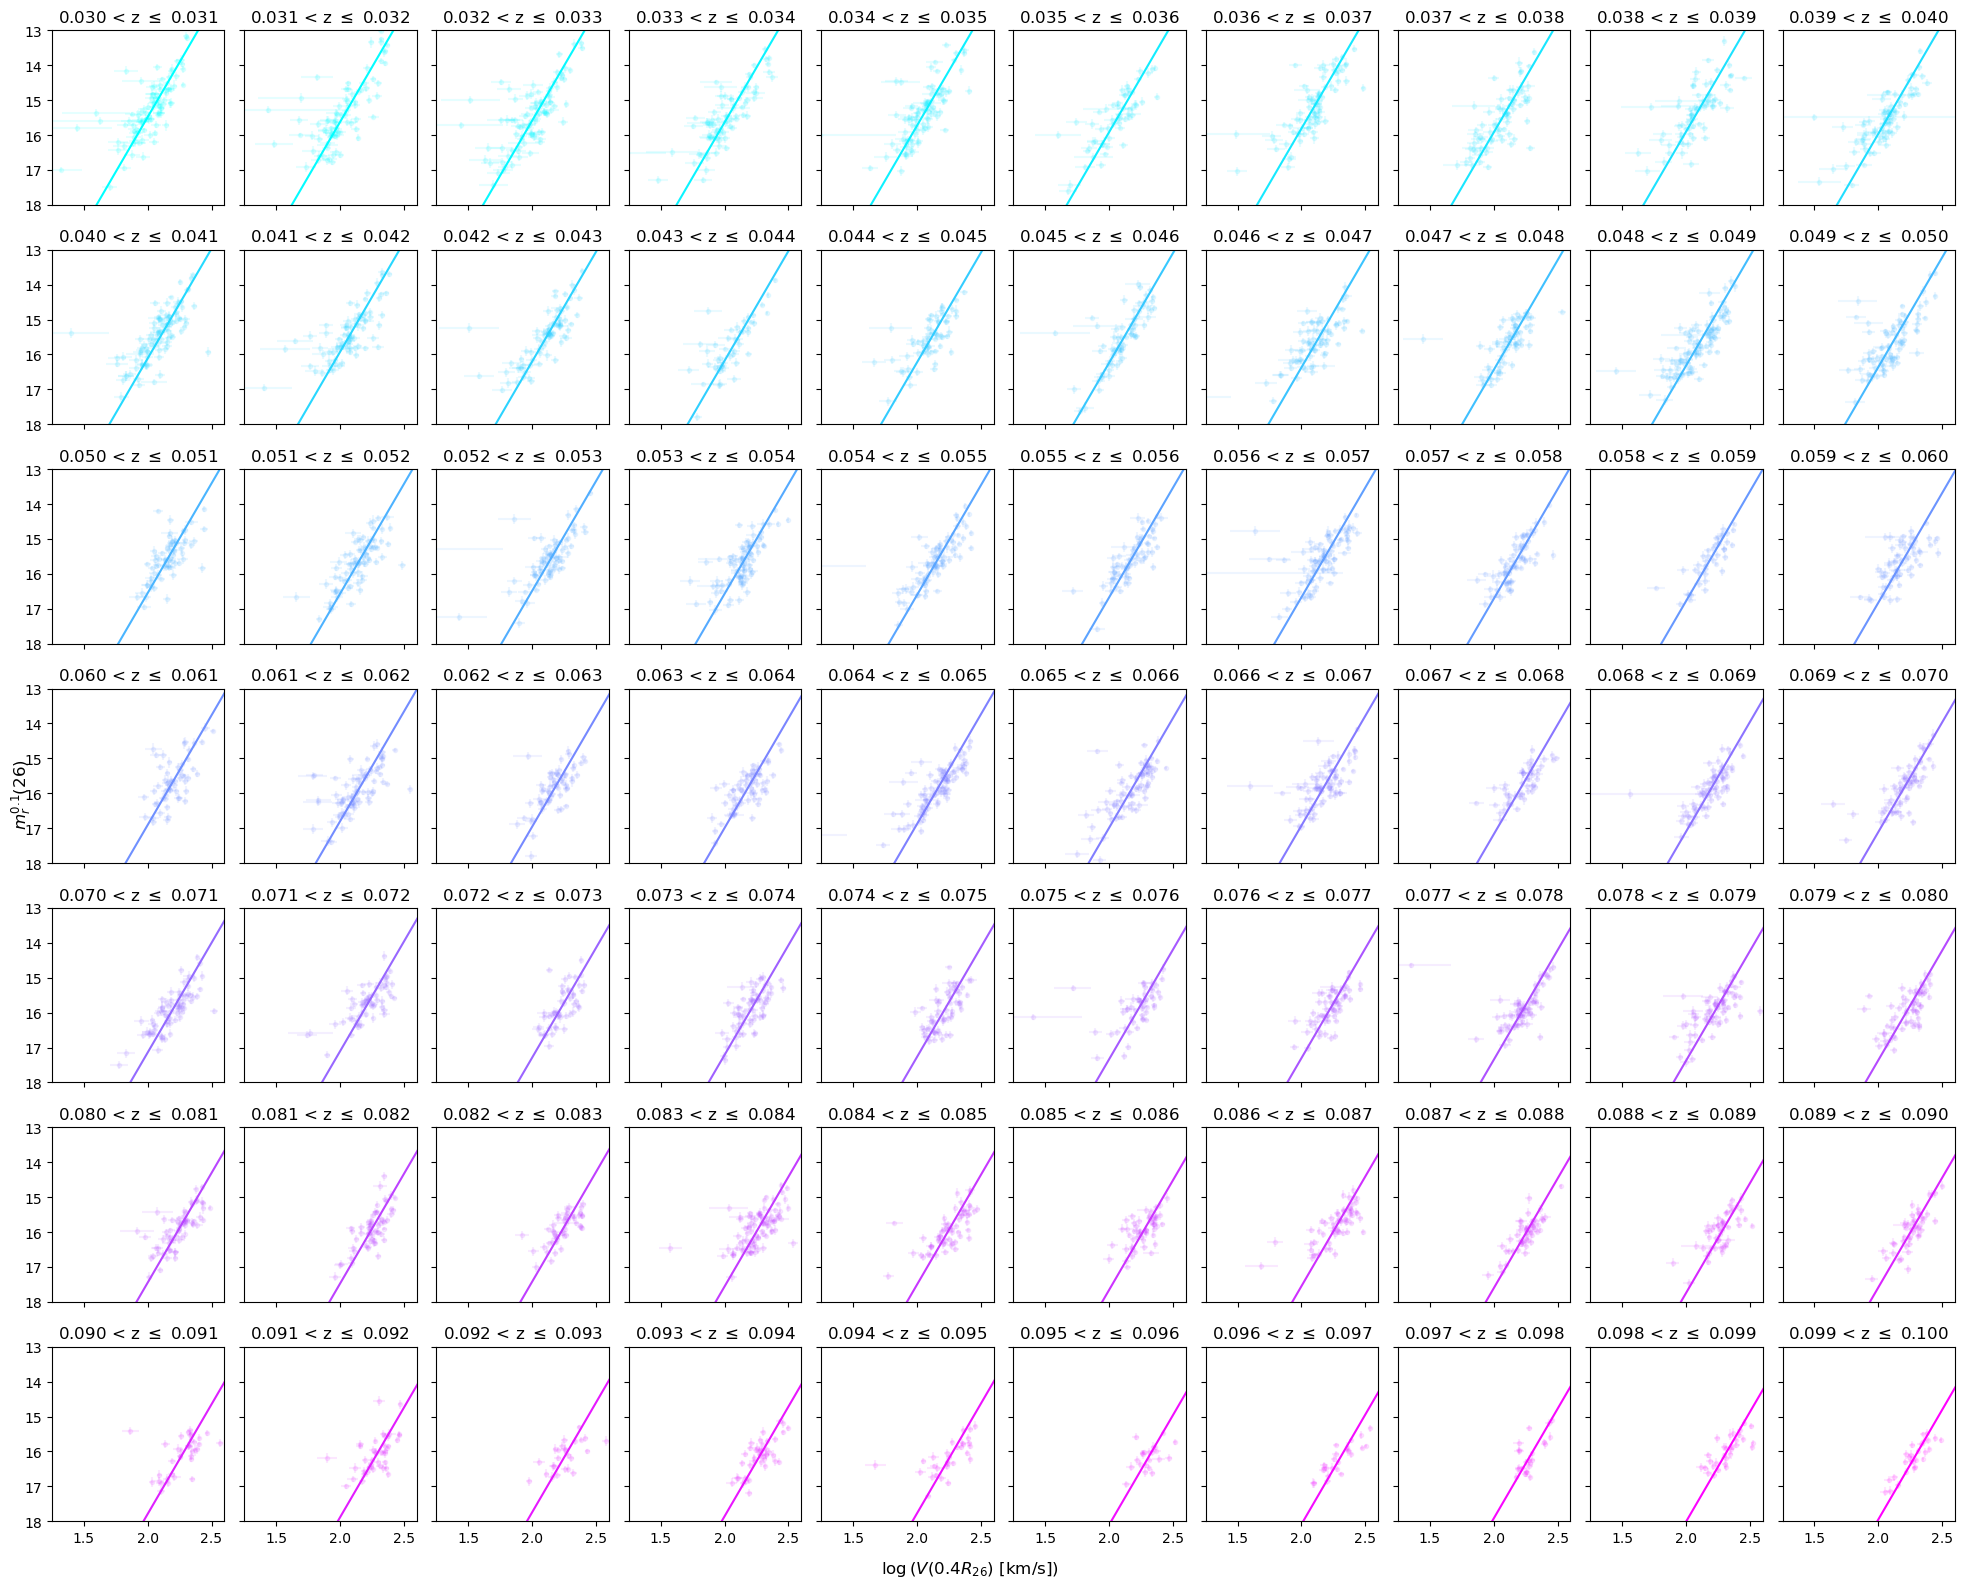

In [71]:
fig, axs = plt.subplots(nrows=7, ncols=10, sharex=True, sharey=True, figsize=(20,16), tight_layout=True)
# fig, axs = plt.subplots(nrows=3, ncols=5, sharex=True, sharey=True, figsize=(10,8), tight_layout=True)

color = iter(plt.cm.cool(np.linspace(0,1,m)))
for i in range(m):
    c = next(color)
    
    row = int(i/10)
    col = i%10
    
    eb = axs[row,col].errorbar(logV[i+1] + logV0, mag[i+1], xerr=logV_err[i+1], yerr=mag_err[i+1], fmt='.', color=c, alpha=0.1)
    axs[row,col].plot(_logv + logV0, a_*_logv + b_[i], color=c)
    
    axs[row,col].set(xlim=[1.25, 2.6], ylim=[18, 13], title=f'{zbins[i]:.3f} < z $\leq$ {zbins[i+1]:.3f}')

# Delete extra axes
# fig.delaxes(axs[-1,-1])

fig.supxlabel(r'$\log{(V(0.4R_{26})~[\mathrm{km/s}]}$)')
fig.supylabel(r'$m_r^{0.1} (26)$');

# plt.savefig('../../Figures/Y1/TF_Y1_individual_cluster_calibration_0pt_binaryMLupdated_z0p1_Anthony2_weightsVmax-1_dVsys_fit0_20250717.png', 
#             dpi=150, 
#             facecolor='none')